In [45]:
import numpy as np
from grakel.datasets import fetch_dataset
from grakel.kernels import WeisfeilerLehman, VertexHistogram, EdgeHistogram, PyramidMatch
from grakel.kernels import SubgraphMatching, GraphletSampling, ShortestPath, RandomWalk, NeighborhoodHash
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [46]:
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

def check_tria_ineq(K_candidate):
    D = 0.5* (np.diag(K_candidate).reshape(-1,1) @ np.ones((K_candidate.shape[0], 1)).T + np.ones((K_candidate.shape[0], 1)) @ np.diag(K_candidate).reshape(1,-1)) - K_candidate
    # sns.heatmap(D)
    # plt.title(f'Distance')
    # plt.show()
    tria_ineq = True
    for x in range(len(D)):
        if not tria_ineq: break
        for y in range(x+1, len(D)):
            if not tria_ineq: break
            for z in range(y+1, len(D)):
                if not tria_ineq: break
                diff1 = D[x,y] + D[x,z] - D[y,z]
                diff2 = D[x,z] + D[y,z] - D[x,y]
                diff3 = D[y,z] + D[x,y] - D[x,z]
                if (diff1 < 0 ) or (diff2 < 0 ) or (diff3 < 0):
                    print(f'Invalid Triangle Inequality (Triplet: No.{x+1,y+1,z+1})')
                    print(f'D[{x},{y}] + D[{x},{z}] - D[{y},{z}] {diff1}')
                    print(f'D[{x},{z}] + D[{y},{z}] - D[{x},{y}] {diff2}')
                    print(f'D[{y},{z}] + D[{x},{y}] - D[{x},{z}] {diff3}')
                    tria_ineq = False

    return tria_ineq

def check_psd(K):
    eigenValues = np.linalg.eigvals(K) #scipy.linalg.eigh(K_new, eigvals_only=True) 
    psd = 'True'
    print("K's min eigenvalue:",min(eigenValues))
    if (0 - min(eigenValues)) > 1e-08: 
        psd = f'False\nmin eig:\n{min(eigenValues)}\nneg eig num:{len(np.argwhere(eigenValues<0))}'
        plt.figure(figsize=(3,2))
        sns.heatmap(K)
        plt.title(f'psd: {psd}')
        plt.show()
        psd = 'True'
        K = K - float(min(eigenValues)) * np.eye(K.shape[0])
        eigenValues = np.linalg.eigvals(K) 
        print("K_new's min eigenvalue:",min(eigenValues))
        if (0 - min(eigenValues)) > 1e-08: 
            psd = f'False\nmin eig:\n{min(eigenValues)}\nneg eig num:{len(np.argwhere(eigenValues<0))}'    
    plt.figure(figsize=(3,2))
    sns.heatmap(K)
    plt.title(f'psd: {psd}')
    plt.show()

In [47]:
dataname = 'MUTAG'

print(f'Fetching {dataname} dataset...')
data = fetch_dataset(dataname.upper(), verbose=False, prefer_attr_nodes=False)
print(f'Finish fetching!')
G, y = data.data, data.target

Fetching MUTAG dataset...
Finish fetching!


In [48]:
G_adj = np.row_stack([np.array(G)[np.where(y == num)[0].astype(np.uint64)] for num in np.unique(y)])
y_adj = np.concatenate([y[np.argwhere(y == num).ravel()] for num in np.unique(y)])

In [49]:
[len(np.where(y_adj == num)[0]) for num in np.unique(y)], len(G_adj)

([63, 125], 188)

In [50]:
K_dict = dict()

# Get Kernels

In [51]:
def get_VH(G):
    wl_kernel = VertexHistogram(normalize=True, sparse='auto')
    K = wl_kernel.fit_transform(G)

    plt.figure(figsize=(3, 2))
    sns.heatmap(K)
    plt.title(f'VH')
    plt.show()
    return K

def get_PM(G, L_value, d_value):
    wl_kernel = PyramidMatch(normalize=True, L = L_value, d = d_value)
    K = wl_kernel.fit_transform(G)

    plt.figure(figsize=(3, 2))
    sns.heatmap(K)
    plt.title(f'PM-{L_value}-{d_value}')
    plt.show()
    return K

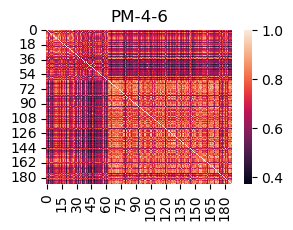

In [52]:
K_dict['K_PM_4_6'] = get_PM(G_adj, 4, 6)

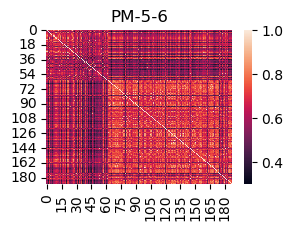

In [53]:
K_dict['K_PM_5_6'] = get_PM(G_adj, 5, 6)

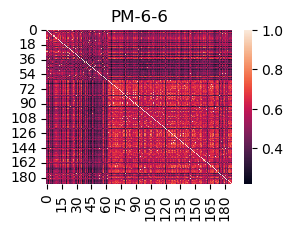

In [54]:
K_dict['K_PM_6_6'] = get_PM(G_adj, 6, 6)

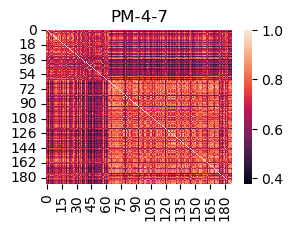

In [55]:
K_dict['K_PM_4_7'] = get_PM(G_adj, 4, 7)

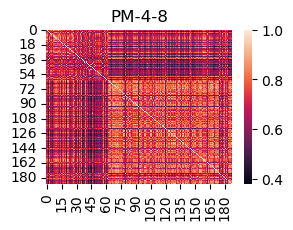

In [56]:
K_dict['K_PM_4_8'] = get_PM(G_adj, 4, 8)

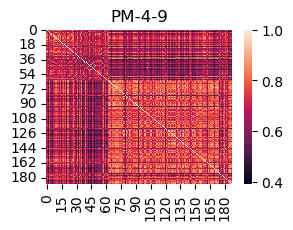

In [57]:
K_dict['K_PM_4_9'] = get_PM(G_adj, 4, 9)

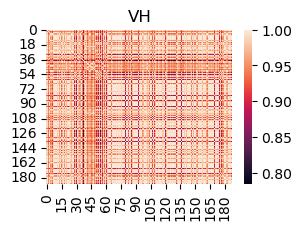

In [58]:
K_dict['K_VH'] = get_VH(G_adj)

In [59]:
def get_NH(G, R_value = 3, bits_value = 8):
    wl_kernel = NeighborhoodHash(normalize=True, R = R_value, bits = bits_value)
    K = wl_kernel.fit_transform(G)

    plt.figure(figsize=(3, 2))
    sns.heatmap(K)
    plt.title(f'NH-{R_value}-{bits_value}')
    plt.show()
    return K

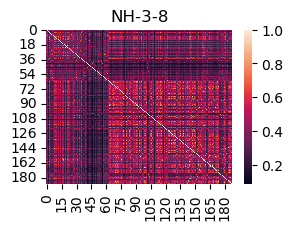

In [60]:
K_dict['K_NH_3_8'] = get_NH(G_adj, 3, 8)

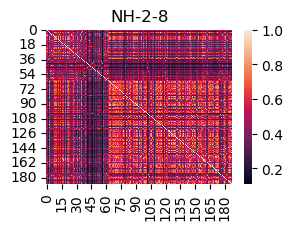

In [61]:
K_dict['K_NH_2_8'] = get_NH(G_adj, 2, 8)

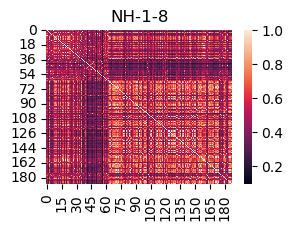

In [62]:
K_dict['K_NH_1_8'] = get_NH(G_adj, 1, 8)

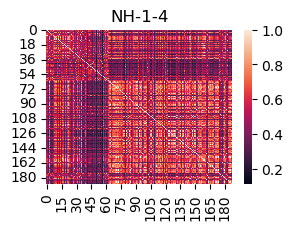

In [63]:
K_dict['K_NH_1_4'] = get_NH(G_adj, 1, 4)

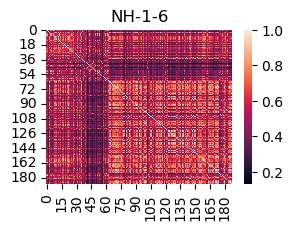

In [64]:
K_dict['K_NH_1_6'] = get_NH(G_adj, 1, 6)

## WL [WeisfeilerLehman]

In [65]:
def get_WL(G, iter_num = 1):
    wl_kernel = WeisfeilerLehman(n_iter=iter_num, normalize=True, base_graph_kernel=VertexHistogram)
    K = wl_kernel.fit_transform(G)

    plt.figure(figsize=(3, 2))
    sns.heatmap(K)
    plt.title(f'WL-{iter_num}')
    plt.show()
    return K

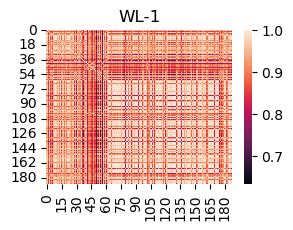

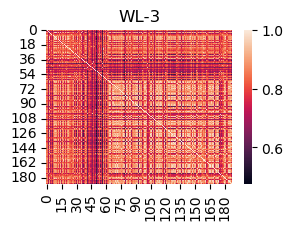

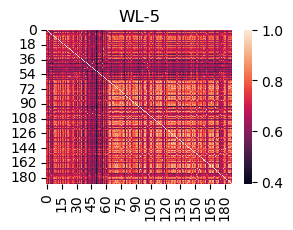

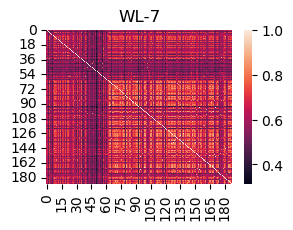

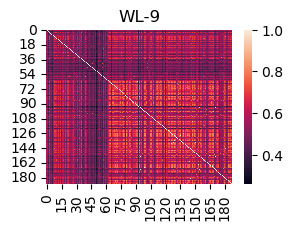

In [87]:
for h in range(1, 10, 2):
    name = f'K_WL_{h}'
    K_dict[name] = get_WL(G_adj, h)

## GS [GraphletSampling]

In [67]:
def get_GS(G, k_num = 4):
    wl_kernel = GraphletSampling(normalize=True, k=k_num)
    K = wl_kernel.fit_transform(G)

    plt.figure(figsize=(3, 2))
    sns.heatmap(K)
    plt.title(f'GS-{k_num} train')
    plt.show()

    return K

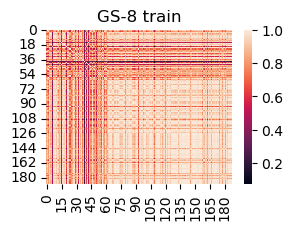

In [68]:
for k in range(8, 9):
    name = f'K_GS_{k}'
    K_dict[name] = get_GS(G_adj, k)

## SP [ShortestPath]

In [69]:
def get_SP(G, algo):
    wl_kernel = ShortestPath(normalize=True, algorithm_type=algo)
    K = wl_kernel.fit_transform(G)

    plt.figure(figsize=(3, 2))
    sns.heatmap(K)
    plt.title(f'SP {algo}')
    plt.show()
    
    return K

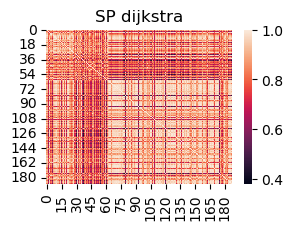

In [70]:
name = f'K_SP'
K_dict[name] = get_SP(G_adj, "dijkstra")

## RW [RandomWalk]

In [71]:
def get_RW(G, lambda_value = 0.1):
    wl_kernel = RandomWalk(lamda=lambda_value, normalize=True, kernel_type="exponential")
    K = wl_kernel.fit_transform(G)

    plt.figure(figsize=(3, 2))
    sns.heatmap(K)
    plt.title(f'RW-{lambda_value}')
    plt.show()

    return K

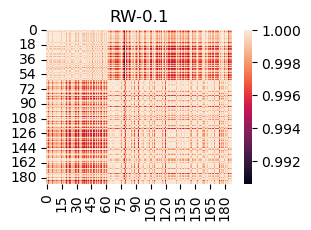

In [72]:
for lam in range(1, 2, 5):
    lam /= 10.
    name = f'K_RW_{lam}'
    K_dict[name] = get_RW(G_adj, lam)

In [73]:
import scipy
from scipy.sparse import csgraph
from sklearn.cluster import SpectralClustering
from sklearn import metrics
import pandas as pd
from sklearn.metrics.cluster import adjusted_rand_score

In [144]:
def cal_acc(y_true, y_pred):
    """
    Calculate clustering accuracy.
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    from scipy.optimize import linear_sum_assignment as linear_assignment
    ind_row, ind_col = linear_assignment(w.max() - w)
    return sum([w[i, j] for i, j in zip(ind_row, ind_col)]) * 1.0 / y_pred.size


def cal_Lap_eigen(K, class_num, gap = True):
    
    num_eigen = 2 if gap else class_num + 1
    L = csgraph.laplacian(K, normed=True)
    eigenValues, eigenVectors = scipy.linalg.eigh(L, subset_by_index=[class_num-num_eigen+1, class_num])
    if gap:
        return (eigenValues, eigenVectors[0], eigenVectors[1])
    else:
        return (eigenValues, eigenVectors) 

def gk_L(K, coef = 1):

    n = K.shape[0]
    D = np.sum(K, axis = 0)

    D15 = np.diag(np.power(D, -1.5))
    D05 = np.diag(np.power(D, -0.5))
    D1 = np.diag(np.power(D, -1))

    U0 = - 0.5 * D15 @ K @ D05 * coef
    U1 = - 0.5 * D05 @ K @ D15 * coef

    U0 = np.tile(U0.sum(axis = 1), (n, 1))
    U1 = np.transpose(np.tile(U1.sum(axis = 0), (n, 1)))
    grad_K = - (U0 + U1 + D1 * coef)
    
    return grad_K

def gw_K(K_list):
    return np.array(K_list)

def get_Knew(prev_w, K_list):
    T = len(prev_w)
    p, q = K_list[0].shape

    K_new = np.zeros((p, q))
    for t in range(T):
        K_new += prev_w[t] * K_list[t]
    return K_new

In [152]:
def cal_grad_w_ratio(K_list, K_new, class_num, return_grad_A = False):
    '''
    obj: eigen-gap ratio
    '''

    eigenValues, eigenV_kp1, eigenV = cal_Lap_eigen(K_new, class_num)
    eigen_k = eigenValues[0]
    eigen_gap = np.diff(eigenValues)
    eigen_gap_ratio = eigen_gap/eigen_k
    eigenV_kp1_trace = np.transpose(eigenV_kp1 @ eigenV_kp1)
    eigenV_trace = np.transpose(eigenV @ eigenV)
    inv_trace1 = np.power(eigen_gap, -1) * (eigenV_kp1_trace - eigenV_trace)
    inv_trace2 = np.power(eigen_k,-1) * (eigenV_trace)

    grad_LK = gk_L(K_new, (inv_trace1 - inv_trace2))
    grad_Lw = gw_K(K_list)
    grad = np.sum(np.sum(grad_Lw * grad_LK, axis = 1), axis = 1)

    if return_grad_A:
        grad_A = grad_LK
        return grad.flatten(), grad_A, eigen_gap_ratio
        
    return grad.flatten(), eigen_gap_ratio


def cal_grad_w_gap(K_list, K_new, class_num, return_grad_A = False):
    '''
    obj: eigen gap
    '''

    eigenValues, eigenV_kp1, eigenV = cal_Lap_eigen(K_new, class_num)
    eigen_k = eigenValues[0]
    eigen_gap = np.diff(eigenValues)
    eigenV_kp1_trace = np.transpose(eigenV_kp1 @ eigenV_kp1)
    eigenV_trace = np.transpose(eigenV @ eigenV)
    inv_trace = np.power(eigen_gap, -1) * (eigenV_kp1_trace - eigenV_trace)

    grad_LK = gk_L(K_new, inv_trace)
    grad_Lw = gw_K(K_list)
    grad = np.sum(np.sum(grad_Lw * grad_LK, axis = 1), axis = 1)

    if return_grad_A:
        grad_A = grad_LK
        return grad.flatten(), grad_A, eigen_gap#_ratio
        
    return grad.flatten(), eigen_gap#_ratio

def cal_grad_w_firstK(K_list, K_new, class_num, return_grad_A = False):
    '''
    obj: first K eigens
    '''

    eigenValues, eigenVectors = cal_Lap_eigen(K_new, class_num, gap = False)
    eig_V = eigenVectors[:, 1:]
    eigenValuesFirst = (1 - eigenValues[1:])[::-1]
    eigenValuesCoef = np.true_divide(1, eigenValuesFirst)
    eig_V= np.multiply(np.power(eigenValuesCoef, 0.5), eig_V)
    coef = np.matmul(eig_V, eig_V.T)

    grad_LK = gk_L(K_new, coef)
    grad_Lw = gw_K(K_list)
    grad = - np.sum(np.sum(grad_Lw * grad_LK, axis = 1), axis = 1)

    if return_grad_A:
        grad_A = grad_LK
        return grad.flatten(), grad_A, np.sum(eigenValues)#_ratio
        
    return grad.flatten(), np.sum(eigenValues)#_ratio

In [75]:
def project_simplex(x):
    """ Take a vector x (with possible nonnegative entries and non-normalized)
        and project it onto the unit simplex.
    """
    xsorted = np.sort(x)[::-1]
    # remaining entries need to sum up to 1
    sum_ = 1.0

    lambda_a = (np.cumsum(xsorted) - sum_) / np.arange(1.0, len(xsorted)+1.0)
    for i in range(len(lambda_a)-1):
        if lambda_a[i] >= xsorted[i+1]:
            astar = i
            break
    else:
        astar = -1

    p = np.maximum(x-lambda_a[astar],  0)
    return p

In [76]:
len(K_dict.values())

16

In [146]:
def train(K_list, init_type, class_num = 2, stepsize = 1e-4, num_iter = 200):
    n = len(K_list)

    score_dict = {'Accuracy': [], "Normalized_Mutual_Info": [], "Adjusted_Rand_Index": []}
    weights_list = []
    gap_list = []

    # initialize weights
    if init_type == 'uniform':
        weights = np.ones(n)/n
        
    elif init_type == 'eigen':
        eigen_weights_list = []
        for K_train in K_list:
            eigenValues, eigenV_kp1, eigenV = cal_Lap_eigen(K_train, class_num)
            eigen_gap = np.diff(eigenValues)
            eigen_weights_list.append(eigen_gap)
        eigen_weights = np.array(eigen_weights_list)
        eigen_weights /= np.sum(eigen_weights)
        weights = eigen_weights.ravel()

    elif init_type == 'eigen_inv':
        eigen_weights_list = []
        for K_train in K_list:
            eigenValues, eigenV_kp1, eigenV = cal_Lap_eigen(K_train, class_num)
            eigen_gap = np.diff(eigenValues)
            eigen_weights_list.append(eigen_gap)
        eigen_weights = np.sum(np.array(eigen_weights_list)) - np.array(eigen_weights_list)
        eigen_weights /= np.sum(eigen_weights)
        weights = eigen_weights.ravel()

    elif init_type == 'random':
        weights = np.random.dirichlet(np.ones(n))

    else:
        weights = init_type


    # num_iter_mom = 50
    # update_w = np.zeros(n)
    for i in range(num_iter):
        # if i < num_iter_mom:
        #     momentum = 0.8
        # else:
        #     momentum = 0.2
        K_new = np.nan_to_num(get_Knew(weights, K_list))
        grad, obj = cal_grad_w_ratio(K_list, K_new, class_num)

        # update_w = (momentum * update_w) + (stepsize * grad)
        # weights += update_w
        weights += (stepsize * grad)
        weights = project_simplex(weights)

        weights_list.append(weights)
        gap_list.append(obj)
        y_pred = SpectralClustering(n_clusters = class_num, 
                                    random_state = 0,
                                    affinity = 'precomputed').fit_predict(K_new)

        acc_score = cal_acc(y_adj, y_pred)
        nmi = metrics.normalized_mutual_info_score(y_adj, y_pred)
        ari = adjusted_rand_score(y_adj, y_pred)
        score_dict['Accuracy'].append(acc_score)
        score_dict['Normalized_Mutual_Info'].append(nmi)
        score_dict['Adjusted_Rand_Index'].append(ari)


        if (i%10 == 0): 
            weight_norm = np.linalg.norm(weights)
            weight_sum = np.sum(weights)
            print(f'----- At No.{i+1} iteration: sum: {np.round(weight_sum, 4)} norm: {np.round(weight_norm, 4)}-----')
            print(f"eigengap ratio: {obj}")
            print(f"acc_score: {acc_score}; nmi: {nmi}; ari: {ari}\n")
            


    plt.plot(range(num_iter), gap_list)
    plt.title(f'Eigengap Ratio')
    plt.xlabel = 'Num of Iterations'
    plt.show()

    return K_new, weights, score_dict

In [118]:
def display_results(kernel_name, K_list, weights, score_dict, num_iter, class_num):
    print('===== Individual acc_score | nmi | ari =====')
    i = 0
    for K_candidate in K_list:
        y_pred = SpectralClustering(n_clusters = class_num, 
                                    random_state = 0,
                                    affinity = 'precomputed').fit_predict(K_candidate)

        acc_score = cal_acc(y_adj, y_pred)
        nmi = metrics.normalized_mutual_info_score(y_adj, y_pred)
        ari = adjusted_rand_score(y_adj, y_pred)
        print("%s: %.4f(acc); %.4f(nmi); %.4f(ari) | weight: %.4f"%(kernel_name[i], acc_score, nmi, ari, weights[i]))
        i += 1

    print('===== Joint kernel =====')
    plt.plot(range(num_iter), pd.DataFrame(score_dict))
    plt.title('Acc: %.4f; NMI: %.4f; ARI: %.4f'%(max(score_dict["Accuracy"]), \
                                                max(score_dict["Normalized_Mutual_Info"]), \
                                                max(score_dict["Adjusted_Rand_Index"])))
    plt.legend(list(score_dict.keys()))
    plt.xlabel = 'Num of Iterations'
    plt.show()

In [161]:
def train_A(K_list, init_type, class_num = 2, stepsize = 1e-4, stepsize_2 = 1e-6, num_iter = 200, obj_type = 'eigenGap'):
    T = len(K_list)

    score_dict = {'Accuracy': [], "Normalized_Mutual_Info": [], "Adjusted_Rand_Index": []}
    weights_list = []
    gap_list = []

    # initialize weights
    if init_type == 'uniform':
        weights = np.ones(T)/T
        
    elif init_type == 'eigen':
        eigen_weights_list = []
        for K_train in K_list:
            eigenValues, eigenV_kp1, eigenV = cal_Lap_eigen(K_train, class_num)
            eigen_gap = np.diff(eigenValues)
            if obj_type == 'eigenGapRatio':
                eigen_weights_list.append(eigen_gap)
            else:
                eigen_weights_list.append(eigen_gap/eigenValues[0])
        eigen_weights = np.array(eigen_weights_list)
        eigen_weights /= np.sum(eigen_weights)
        weights = eigen_weights.ravel()

    elif init_type == 'eigen_inv':
        eigen_weights_list = []
        for K_train in K_list:
            eigenValues, eigenV_kp1, eigenV = cal_Lap_eigen(K_train, class_num)
            eigen_gap = np.diff(eigenValues)
            if obj_type == 'eigenGapRatio':
                eigen_weights_list.append(eigen_gap)
            else:
                eigen_weights_list.append(eigen_gap/eigenValues[0])
        eigen_weights = np.sum(np.array(eigen_weights_list)) - np.array(eigen_weights_list)
        eigen_weights /= np.sum(eigen_weights)
        weights = eigen_weights.ravel()

    elif init_type == 'random':
        weights = np.random.dirichlet(np.ones(T))

    else:
        weights = init_type

    K_best = np.zeros(K_list[0].shape)
    score_best = 0
    A = np.zeros(K_list[0].shape)#np.random.random(K_list[0].shape) * 1e-4
    # num_iter_mom = 50
    # update_w = np.zeros(n)
    for i in range(num_iter):
        # if i < num_iter_mom:
        #     momentum = 0.8
        # else:
        #     momentum = 0.2
        K_new = np.nan_to_num(get_Knew(weights, K_list) + A)
        if obj_type == 'eigenGapRatio':
            grad, grad_A, obj = cal_grad_w_ratio(K_list, K_new, class_num, return_grad_A=True)
        elif obj_type == 'eigenGap':
            grad, grad_A, obj = cal_grad_w_gap(K_list, K_new, class_num, return_grad_A=True)
        elif obj_type == 'firstK':
            grad, grad_A, obj = cal_grad_w_firstK(K_list, K_new, class_num, return_grad_A=True)
        A += (stepsize_2 * grad_A - A)

        # update_w = (momentum * update_w) + (stepsize * grad)
        # weights += update_w
        weights += (stepsize * grad)
        weights = project_simplex(weights)

        weights_list.append(weights)
        gap_list.append(obj)
        y_pred = SpectralClustering(n_clusters = class_num, 
                                    random_state = 0,
                                    affinity = 'precomputed').fit_predict(K_new)

        acc_score = cal_acc(y_adj, y_pred)
        nmi = metrics.normalized_mutual_info_score(y_adj, y_pred)
        ari = adjusted_rand_score(y_adj, y_pred)
        score_dict['Accuracy'].append(acc_score)
        score_dict['Normalized_Mutual_Info'].append(nmi)
        score_dict['Adjusted_Rand_Index'].append(ari)

        if score_best < acc_score: K_best = K_new

        if (i%10 == 0): 
            weight_norm = np.linalg.norm(weights)
            weight_sum = np.sum(weights)
            grad_norm = np.linalg.norm(grad)
            print(f'----- No.{i+1} iteration: {np.round(grad_norm, 4)}(g norm) {np.round(weight_sum, 4)}(w sum) {np.round(weight_norm, 4)}(w norm)-----')
            if obj_type == 'eigenGapRatio':
                print(f"eigengap ratio: {obj}")
            elif obj_type == 'eigenGap':
                print(f"eigengap: {obj}")
            elif obj_type == 'firstK':
                print(f"sum of firstK: {obj}")
            print(f"acc_score: {acc_score}; nmi: {nmi}; ari: {ari}\n")

    plt.plot(range(num_iter), gap_list)
    if obj_type == 'eigenGapRatio':
        plt.title(f'Eigengap Ratio')
    elif obj_type == 'eigenGap':
        plt.title(f'Eigen Gap')
    elif obj_type == 'firstK':
        plt.title(f'First K')
    plt.xlabel = 'Num of Iterations'
    plt.show()

    return K_new, K_best, A, weights, score_dict

----- No.1 iteration: 5.5255(g norm) 1.0(w sum) 0.224(w norm)-----
eigengap: [0.04805208]
acc_score: 0.5851063829787234; nmi: 0.17666774146146513; ari: 0.24412005918591528

----- No.11 iteration: 3.6565(g norm) 1.0(w sum) 0.2547(w norm)-----
eigengap: [0.06138466]
acc_score: 0.574468085106383; nmi: 0.18165729852067422; ari: 0.24465763246911065

----- No.21 iteration: 2.1418(g norm) 1.0(w sum) 0.2784(w norm)-----
eigengap: [0.06687382]
acc_score: 0.5691489361702128; nmi: 0.17535270896623112; ari: 0.23430258577904176

----- No.31 iteration: 0.9736(g norm) 1.0(w sum) 0.2885(w norm)-----
eigengap: [0.06850784]
acc_score: 0.5691489361702128; nmi: 0.17535270896623112; ari: 0.23430258577904176

----- No.41 iteration: 0.4416(g norm) 1.0(w sum) 0.2926(w norm)-----
eigengap: [0.06918081]
acc_score: 0.5691489361702128; nmi: 0.17535270896623112; ari: 0.23430258577904176

----- No.51 iteration: 0.2004(g norm) 1.0(w sum) 0.2946(w norm)-----
eigengap: [0.06948912]
acc_score: 0.5691489361702128; nmi: 

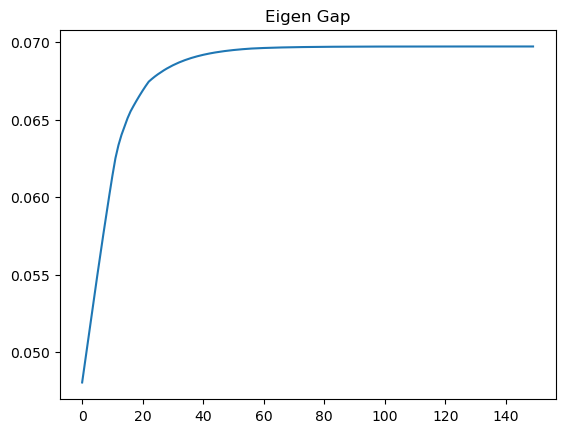

===== Individual acc_score | nmi | ari =====
K_PM_4_6: 0.7287(acc); 0.3259(nmi); 0.4489(ari) | weight: 0.0323
K_PM_5_6: 0.7287(acc); 0.3259(nmi); 0.4489(ari) | weight: 0.0582
K_PM_6_6: 0.7287(acc); 0.3259(nmi); 0.4489(ari) | weight: 0.0903
K_PM_4_7: 0.7234(acc); 0.3393(nmi); 0.4645(ari) | weight: 0.0338
K_PM_4_8: 0.7234(acc); 0.3393(nmi); 0.4645(ari) | weight: 0.0348
K_PM_4_9: 0.7234(acc); 0.3393(nmi); 0.4645(ari) | weight: 0.0352
K_VH: 0.6330(acc); 0.0691(nmi); 0.1202(ari) | weight: 0.0000
K_NH_3_8: 0.5691(acc); 0.1754(nmi); 0.2343(ari) | weight: 0.1440
K_NH_2_8: 0.5851(acc); 0.1949(nmi); 0.2660(ari) | weight: 0.1114
K_NH_1_8: 0.5691(acc); 0.1754(nmi); 0.2343(ari) | weight: 0.0967
K_NH_1_4: 0.5798(acc); 0.1882(nmi); 0.2552(ari) | weight: 0.0941
K_NH_1_6: 0.5585(acc); 0.1633(nmi); 0.2142(ari) | weight: 0.0914
K_WL_1: 0.5532(acc); 0.1263(nmi); 0.1672(ari) | weight: 0.0000
K_GS_8: 0.5957(acc); 0.0122(nmi); 0.0243(ari) | weight: 0.0000
K_SP: 0.6755(acc); 0.2106(nmi); 0.3180(ari) | weight:

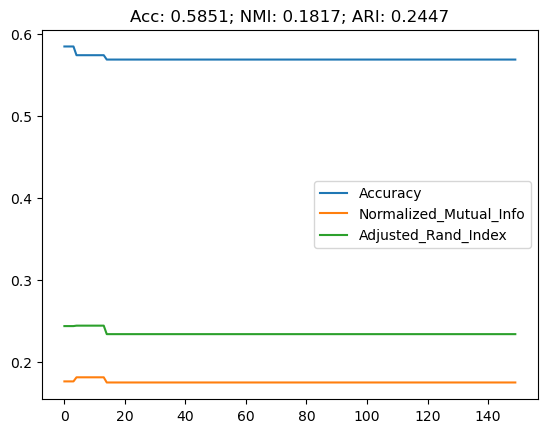

In [173]:
K_list = list(K_dict.values())
num_iter = 150
class_num = len(np.unique(y))
K_new, K_best, A_new, weights, score_dict = train_A(K_list, 'uniform', class_num, 1e-2, 0, num_iter)
display_results(list(K_dict.keys()), K_list, weights, score_dict, num_iter, class_num)

----- No.1 iteration: 5.5255(g norm) 1.0(w sum) 0.2236(w norm)-----
eigengap: [0.04805208]
acc_score: 0.5851063829787234; nmi: 0.17666774146146513; ari: 0.24412005918591528

----- No.11 iteration: 5.3803(g norm) 1.0(w sum) 0.2241(w norm)-----
eigengap: [0.04941862]
acc_score: 0.5851063829787234; nmi: 0.17666774146146513; ari: 0.24412005918591528

----- No.21 iteration: 5.2149(g norm) 1.0(w sum) 0.2252(w norm)-----
eigengap: [0.05078676]
acc_score: 0.5851063829787234; nmi: 0.17666774146146513; ari: 0.24412005918591528

----- No.31 iteration: 5.0352(g norm) 1.0(w sum) 0.2271(w norm)-----
eigengap: [0.05214989]
acc_score: 0.5851063829787234; nmi: 0.17666774146146513; ari: 0.24412005918591528

----- No.41 iteration: 4.8462(g norm) 1.0(w sum) 0.2294(w norm)-----
eigengap: [0.05350229]
acc_score: 0.574468085106383; nmi: 0.18165729852067422; ari: 0.24465763246911065

----- No.51 iteration: 4.6517(g norm) 1.0(w sum) 0.2322(w norm)-----
eigengap: [0.05483906]
acc_score: 0.574468085106383; nmi: 

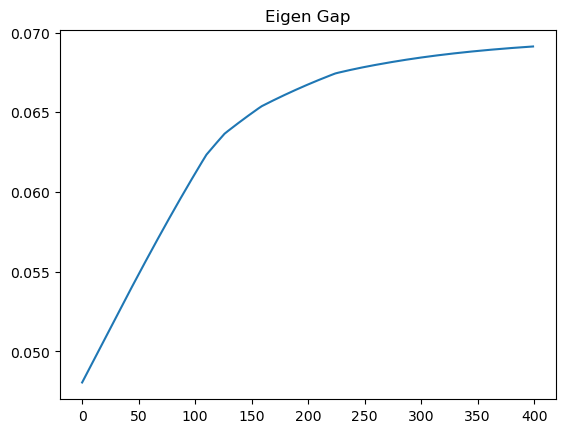

===== Individual acc_score | nmi | ari =====
K_PM_4_6: 0.7287(acc); 0.3259(nmi); 0.4489(ari) | weight: 0.0345
K_PM_5_6: 0.7287(acc); 0.3259(nmi); 0.4489(ari) | weight: 0.0588
K_PM_6_6: 0.7287(acc); 0.3259(nmi); 0.4489(ari) | weight: 0.0889
K_PM_4_7: 0.7234(acc); 0.3393(nmi); 0.4645(ari) | weight: 0.0359
K_PM_4_8: 0.7234(acc); 0.3393(nmi); 0.4645(ari) | weight: 0.0369
K_PM_4_9: 0.7234(acc); 0.3393(nmi); 0.4645(ari) | weight: 0.0372
K_VH: 0.6330(acc); 0.0691(nmi); 0.1202(ari) | weight: 0.0000
K_NH_3_8: 0.5691(acc); 0.1754(nmi); 0.2343(ari) | weight: 0.1393
K_NH_2_8: 0.5851(acc); 0.1949(nmi); 0.2660(ari) | weight: 0.1087
K_NH_1_8: 0.5691(acc); 0.1754(nmi); 0.2343(ari) | weight: 0.0950
K_NH_1_4: 0.5798(acc); 0.1882(nmi); 0.2552(ari) | weight: 0.0925
K_NH_1_6: 0.5585(acc); 0.1633(nmi); 0.2142(ari) | weight: 0.0899
K_WL_1: 0.5532(acc); 0.1263(nmi); 0.1672(ari) | weight: 0.0000
K_GS_8: 0.5957(acc); 0.0122(nmi); 0.0243(ari) | weight: 0.0000
K_SP: 0.6755(acc); 0.2106(nmi); 0.3180(ari) | weight:

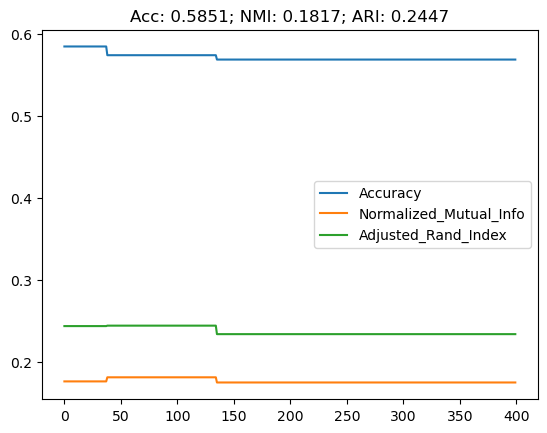

In [176]:
K_list = list(K_dict.values())
num_iter = 400
class_num = len(np.unique(y))
K_new, K_best, A_new, weights, score_dict = train_A(K_list, 'uniform', class_num, 1e-3, 0, num_iter)
display_results(list(K_dict.keys()), K_list, weights, score_dict, num_iter, class_num)

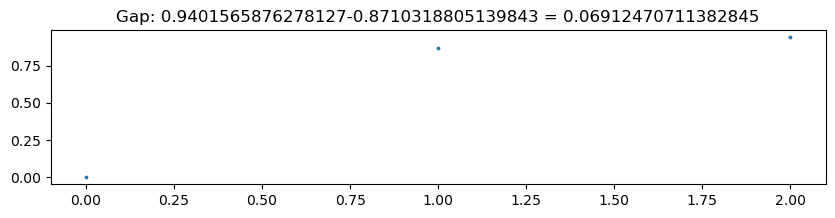

In [181]:
L = csgraph.laplacian(K_new, normed=True)
eigenValues, eigenVectors = scipy.linalg.eigh(L, subset_by_index=[0,2])
plt.figure(figsize = (10,2))
plt.scatter(np.arange(len(eigenValues)), eigenValues, s = 3)
plt.title(f"Gap: {eigenValues[2]}-{eigenValues[1]} = {eigenValues[2]-eigenValues[1]}")
plt.show()

----- No.1 iteration: 13.787(g norm) 1.0(w sum) 0.2236(w norm)-----
eigengap ratio: [0.05142985]
acc_score: 0.5851063829787234; nmi: 0.17666774146146513; ari: 0.24412005918591528

----- No.11 iteration: 13.9555(g norm) 1.0(w sum) 0.2259(w norm)-----
eigengap ratio: [0.05570214]
acc_score: 0.5851063829787234; nmi: 0.17666774146146513; ari: 0.24412005918591528

----- No.21 iteration: 14.0165(g norm) 1.0(w sum) 0.2331(w norm)-----
eigengap ratio: [0.06044683]
acc_score: 0.574468085106383; nmi: 0.18165729852067422; ari: 0.24465763246911065

----- No.31 iteration: 14.023(g norm) 1.0(w sum) 0.2448(w norm)-----
eigengap ratio: [0.06571053]
acc_score: 0.574468085106383; nmi: 0.18165729852067422; ari: 0.24465763246911065

----- No.41 iteration: 13.9974(g norm) 1.0(w sum) 0.2594(w norm)-----
eigengap ratio: [0.07118215]
acc_score: 0.574468085106383; nmi: 0.18165729852067422; ari: 0.24465763246911065

----- No.51 iteration: 13.826(g norm) 1.0(w sum) 0.2712(w norm)-----
eigengap ratio: [0.07445624

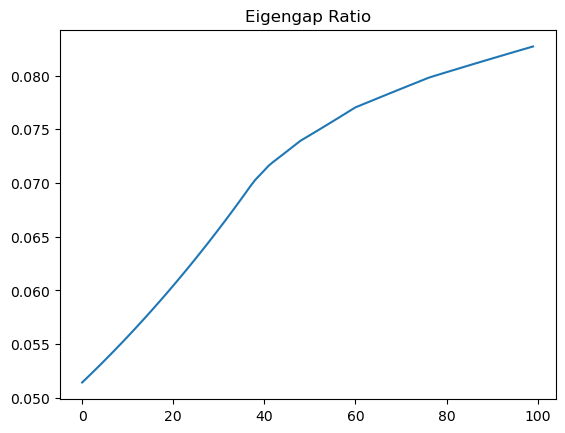

===== Individual acc_score | nmi | ari =====
K_PM_4_6: 0.7287(acc); 0.3259(nmi); 0.4489(ari) | weight: 0.0224
K_PM_5_6: 0.7287(acc); 0.3259(nmi); 0.4489(ari) | weight: 0.0546
K_PM_6_6: 0.7287(acc); 0.3259(nmi); 0.4489(ari) | weight: 0.0949
K_PM_4_7: 0.7234(acc); 0.3393(nmi); 0.4645(ari) | weight: 0.0243
K_PM_4_8: 0.7234(acc); 0.3393(nmi); 0.4645(ari) | weight: 0.0256
K_PM_4_9: 0.7234(acc); 0.3393(nmi); 0.4645(ari) | weight: 0.0261
K_VH: 0.6330(acc); 0.0691(nmi); 0.1202(ari) | weight: 0.0000
K_NH_3_8: 0.5691(acc); 0.1754(nmi); 0.2343(ari) | weight: 0.1621
K_NH_2_8: 0.5851(acc); 0.1949(nmi); 0.2660(ari) | weight: 0.1214
K_NH_1_8: 0.5691(acc); 0.1754(nmi); 0.2343(ari) | weight: 0.1026
K_NH_1_4: 0.5798(acc); 0.1882(nmi); 0.2552(ari) | weight: 0.0985
K_NH_1_6: 0.5585(acc); 0.1633(nmi); 0.2142(ari) | weight: 0.0961
K_WL_1: 0.5532(acc); 0.1263(nmi); 0.1672(ari) | weight: 0.0000
K_GS_8: 0.5957(acc); 0.0122(nmi); 0.0243(ari) | weight: 0.0000
K_SP: 0.6755(acc); 0.2106(nmi); 0.3180(ari) | weight:

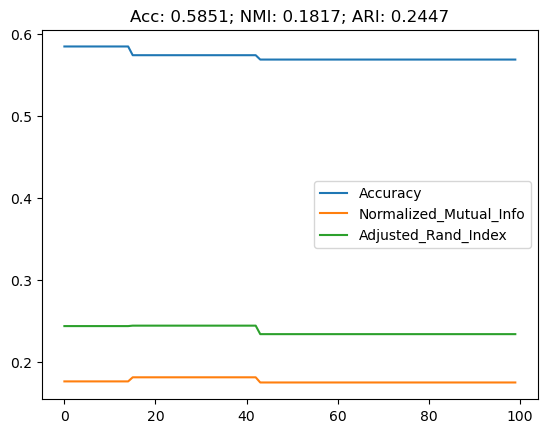

In [131]:
K_list = list(K_dict.values())
num_iter = 100
class_num = len(np.unique(y))
K_new, K_best, A_new, weights, score_dict = train_A(K_list, 'uniform', class_num, 1e-3, 0, num_iter, obj_type='eigenGapRatio')
display_results(list(K_dict.keys()), K_list, weights, score_dict, num_iter, class_num)

In [ ]:
L = csgraph.laplacian(K_new, normed=True)
eigenValues, eigenVectors = scipy.linalg.eigh(L, subset_by_index=[0,2])
plt.figure(figsize = (10,2))
plt.scatter(np.arange(len(eigenValues)), eigenValues, s = 3)
plt.title(f"Gap: {(eigenValues[2]-eigenValues[1])/eigenValues[1]}")
plt.show()

----- No.1 iteration: 13.5856(g norm) 1.0(w sum) 0.2245(w norm)-----
sum of firstK: 1.8895857288808535
acc_score: 0.5851063829787234; nmi: 0.17666774146146513; ari: 0.24412005918591528

----- No.11 iteration: 15.4561(g norm) 1.0(w sum) 0.2869(w norm)-----
sum of firstK: 1.8178668320862537
acc_score: 0.5691489361702128; nmi: 0.17535270896623112; ari: 0.23430258577904176

----- No.21 iteration: 16.4174(g norm) 1.0(w sum) 0.3429(w norm)-----
sum of firstK: 1.7851228139749573
acc_score: 0.5691489361702128; nmi: 0.17535270896623112; ari: 0.23430258577904176

----- No.31 iteration: 17.0614(g norm) 1.0(w sum) 0.3823(w norm)-----
sum of firstK: 1.7621942653742353
acc_score: 0.5691489361702128; nmi: 0.17535270896623112; ari: 0.23430258577904176

----- No.41 iteration: 17.4717(g norm) 1.0(w sum) 0.4155(w norm)-----
sum of firstK: 1.7450099333297158
acc_score: 0.5797872340425532; nmi: 0.1881565335237106; ari: 0.2552296798852584

----- No.51 iteration: 17.7021(g norm) 1.0(w sum) 0.4367(w norm)----

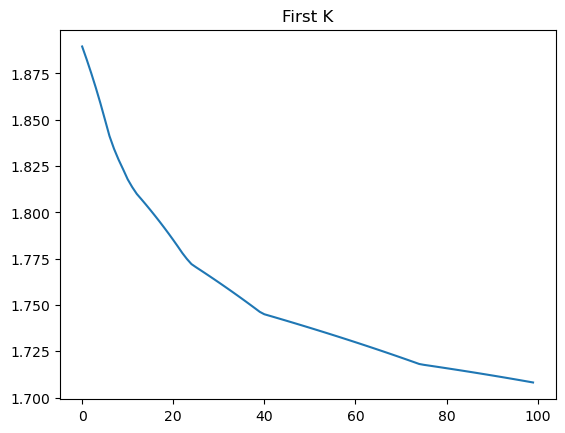

===== Individual acc_score | nmi | ari =====
K_PM_4_6: 0.7287(acc); 0.3259(nmi); 0.4489(ari) | weight: 0.0000
K_PM_5_6: 0.7287(acc); 0.3259(nmi); 0.4489(ari) | weight: 0.0000
K_PM_6_6: 0.7287(acc); 0.3259(nmi); 0.4489(ari) | weight: 0.0164
K_PM_4_7: 0.7234(acc); 0.3393(nmi); 0.4645(ari) | weight: 0.0000
K_PM_4_8: 0.7234(acc); 0.3393(nmi); 0.4645(ari) | weight: 0.0000
K_PM_4_9: 0.7234(acc); 0.3393(nmi); 0.4645(ari) | weight: 0.0000
K_VH: 0.6330(acc); 0.0691(nmi); 0.1202(ari) | weight: 0.0000
K_NH_3_8: 0.5691(acc); 0.1754(nmi); 0.2343(ari) | weight: 0.5010
K_NH_2_8: 0.5851(acc); 0.1949(nmi); 0.2660(ari) | weight: 0.2350
K_NH_1_8: 0.5691(acc); 0.1754(nmi); 0.2343(ari) | weight: 0.1127
K_NH_1_4: 0.5798(acc); 0.1882(nmi); 0.2552(ari) | weight: 0.0780
K_NH_1_6: 0.5585(acc); 0.1633(nmi); 0.2142(ari) | weight: 0.0570
K_WL_1: 0.5532(acc); 0.1263(nmi); 0.1672(ari) | weight: 0.0000
K_GS_8: 0.5957(acc); 0.0122(nmi); 0.0243(ari) | weight: 0.0000
K_SP: 0.6755(acc); 0.2106(nmi); 0.3180(ari) | weight:

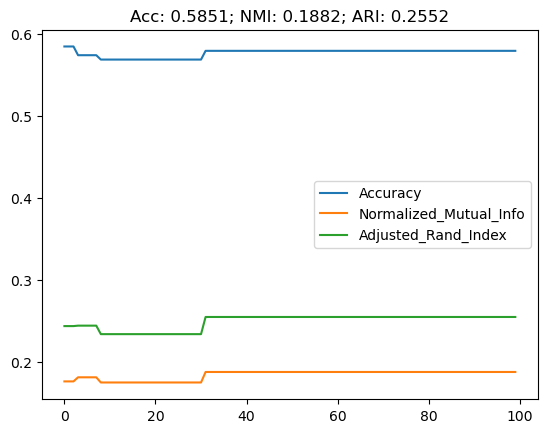

In [166]:
K_list = list(K_dict.values())
num_iter = 100
class_num = len(np.unique(y))
K_new, K_best, A_new, weights, score_dict = train_A(K_list, 'uniform', class_num, 5e-3, 0, num_iter, obj_type='firstK')
display_results(list(K_dict.keys()), K_list, weights, score_dict, num_iter, class_num)

----- No.1 iteration: 3391.7705(g norm) 1.0(w sum) 0.6144(w norm)-----
eigengap: [0.00141496]
acc_score: 0.7978723404255319; nmi: 0.09870507937275586; ari: 0.17487069048048542

----- No.11 iteration: 2194.2533(g norm) 1.0(w sum) 0.606(w norm)-----
eigengap: [0.00220092]
acc_score: 0.8351063829787234; nmi: 0.128310645227208; ari: 0.19819947955937495

----- No.21 iteration: 1523.7721(g norm) 1.0(w sum) 0.6235(w norm)-----
eigengap: [0.00317718]
acc_score: 0.5638297872340425; nmi: 0.007952491621296229; ari: 0.012747890645960477

----- No.31 iteration: 1207.6792(g norm) 1.0(w sum) 0.6475(w norm)-----
eigengap: [0.00401424]
acc_score: 0.5691489361702128; nmi: 0.009206013626100022; ari: 0.0155318960016251

----- No.41 iteration: 1020.3097(g norm) 1.0(w sum) 0.6737(w norm)-----
eigengap: [0.00475567]
acc_score: 0.5638297872340425; nmi: 0.007952491621296229; ari: 0.012747890645960477

----- No.51 iteration: 893.9353(g norm) 1.0(w sum) 0.7005(w norm)-----
eigengap: [0.00543144]
acc_score: 0.563

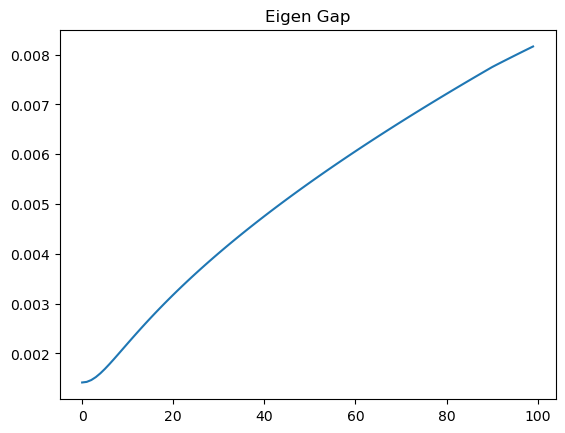

===== Individual acc_score | nmi | ari =====
K_GS_8: 0.5957(acc); 0.0122(nmi); 0.0243(ari) | weight: 0.7779
K_WL_1: 0.5532(acc); 0.1263(nmi); 0.1672(ari) | weight: 0.2221
K_RW_0.1: 0.5426(acc); 0.4301(nmi); 0.4753(ari) | weight: 0.0000
===== Joint kernel =====


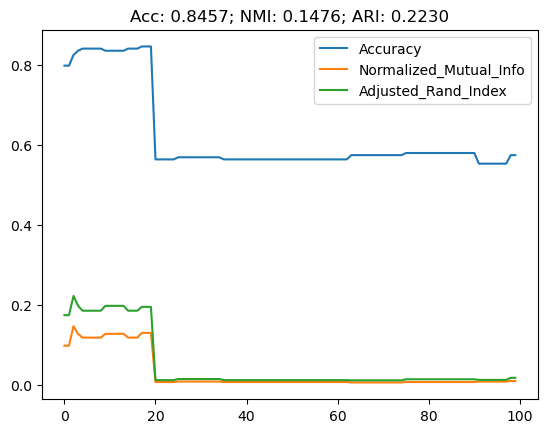

In [133]:
k_name = ["K_GS_8", "K_WL_1", "K_RW_0.1"]
K_list = [K_dict[k] for k in k_name]
num_iter = 100
class_num = len(np.unique(y))
K_new, K_best, A_new, weights, score_dict = train_A(K_list, 'eigen_inv', class_num, 1e-4, 0, num_iter)
display_results(k_name, K_list, weights, score_dict, num_iter, class_num)

----- No.1 iteration: 3441.3683(g norm) 1.0(w sum) 0.6182(w norm)-----
eigengap ratio: [0.00141476]
acc_score: 0.7978723404255319; nmi: 0.09870507937275586; ari: 0.17487069048048542

----- No.11 iteration: 3388.7403(g norm) 1.0(w sum) 0.6144(w norm)-----
eigengap ratio: [0.00143916]
acc_score: 0.824468085106383; nmi: 0.1475539867860813; ari: 0.22302171982549107

----- No.21 iteration: 3282.279(g norm) 1.0(w sum) 0.6112(w norm)-----
eigengap ratio: [0.00148816]
acc_score: 0.8297872340425532; nmi: 0.13784960147580697; ari: 0.2105203146988204

----- No.31 iteration: 3141.0829(g norm) 1.0(w sum) 0.6087(w norm)-----
eigengap ratio: [0.00155736]
acc_score: 0.8351063829787234; nmi: 0.128310645227208; ari: 0.19819947955937495

----- No.41 iteration: 2984.1834(g norm) 1.0(w sum) 0.6069(w norm)-----
eigengap ratio: [0.00164154]
acc_score: 0.8404255319148937; nmi: 0.11893831044436512; ari: 0.18605913721577463

----- No.51 iteration: 2825.6286(g norm) 1.0(w sum) 0.6057(w norm)-----
eigengap ratio:

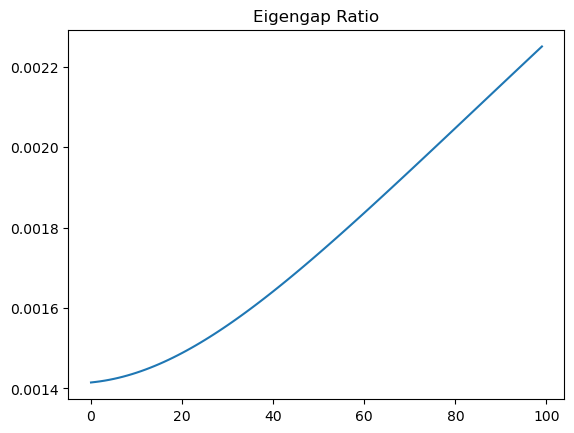

===== Individual acc_score | nmi | ari =====
K_GS_8: 0.5957(acc); 0.0122(nmi); 0.0243(ari) | weight: 0.4427
K_WL_1: 0.5532(acc); 0.1263(nmi); 0.1672(ari) | weight: 0.1907
K_RW_0.1: 0.5426(acc); 0.4301(nmi); 0.4753(ari) | weight: 0.3666
===== Joint kernel =====


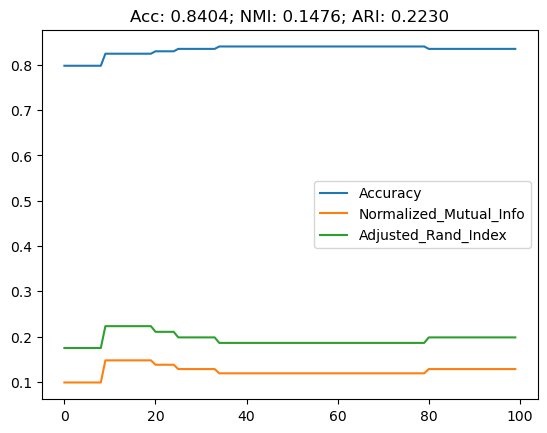

In [137]:
k_name = ["K_GS_8", "K_WL_1", "K_RW_0.1"]
K_list = [K_dict[k] for k in k_name]
num_iter = 100
class_num = len(np.unique(y))
K_new, K_best, A_new, weights, score_dict = train_A(K_list, 'eigen_inv', class_num, 1e-5, 1e-3, num_iter, obj_type='eigenGapRatio')
display_results(k_name, K_list, weights, score_dict, num_iter, class_num)

----- No.1 iteration: 3.4257(g norm) 1.0(w sum) 0.6176(w norm)-----
sum of firstK: 1.976502164704705
acc_score: 0.7978723404255319; nmi: 0.09870507937275586; ari: 0.17487069048048542

----- No.11 iteration: 3.4765(g norm) 1.0(w sum) 0.6124(w norm)-----
sum of firstK: 1.9728540180214933
acc_score: 0.8404255319148937; nmi: 0.11893831044436512; ari: 0.18605913721577463

----- No.21 iteration: 3.538(g norm) 1.0(w sum) 0.6123(w norm)-----
sum of firstK: 1.969124539450625
acc_score: 0.8351063829787234; nmi: 0.128310645227208; ari: 0.19819947955937495

----- No.31 iteration: 3.605(g norm) 1.0(w sum) 0.6172(w norm)-----
sum of firstK: 1.9652891265636638
acc_score: 0.5691489361702128; nmi: 0.009206013626100022; ari: 0.0155318960016251

----- No.41 iteration: 3.6758(g norm) 1.0(w sum) 0.6271(w norm)-----
sum of firstK: 1.9613267627891302
acc_score: 0.5638297872340425; nmi: 0.007952491621296229; ari: 0.012747890645960477

----- No.51 iteration: 3.7499(g norm) 1.0(w sum) 0.6419(w norm)-----
sum of

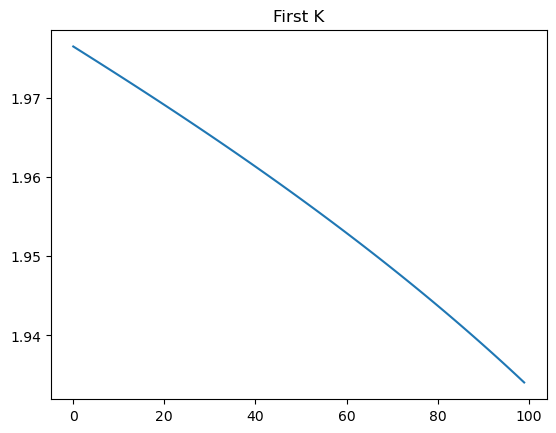

===== Individual acc_score | nmi | ari =====
K_GS_8: 0.5957(acc); 0.0122(nmi); 0.0243(ari) | weight: 0.7650
K_WL_1: 0.5532(acc); 0.1263(nmi); 0.1672(ari) | weight: 0.1077
K_RW_0.1: 0.5426(acc); 0.4301(nmi); 0.4753(ari) | weight: 0.1273
===== Joint kernel =====


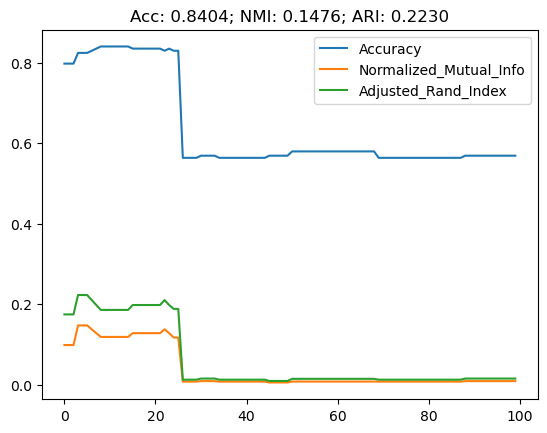

In [164]:
k_name = ["K_GS_8", "K_WL_1", "K_RW_0.1"]
K_list = [K_dict[k] for k in k_name]
num_iter = 100
class_num = len(np.unique(y))
K_new, K_best, A_new, weights, score_dict = train_A(K_list, 'eigen_inv', class_num, 1e-2, 1e-3, num_iter, obj_type='firstK')
display_results(k_name, K_list, weights, score_dict, num_iter, class_num)

----- No.1 iteration: 847.3368(g norm) 1.0(w sum) 0.5774(w norm)-----
eigengap: [0.00561374]
acc_score: 0.6808510638297872; nmi: 0.12921121983813993; ari: 0.21475002359545706

----- No.11 iteration: 855.5925(g norm) 1.0(w sum) 0.5774(w norm)-----
eigengap: [0.00556401]
acc_score: 0.6808510638297872; nmi: 0.12921121983813993; ari: 0.21475002359545706

----- No.21 iteration: 864.029(g norm) 1.0(w sum) 0.5774(w norm)-----
eigengap: [0.00551392]
acc_score: 0.6808510638297872; nmi: 0.12921121983813993; ari: 0.21475002359545706

----- No.31 iteration: 872.6548(g norm) 1.0(w sum) 0.5776(w norm)-----
eigengap: [0.00546355]
acc_score: 0.6808510638297872; nmi: 0.12921121983813993; ari: 0.21475002359545706

----- No.41 iteration: 881.477(g norm) 1.0(w sum) 0.5777(w norm)-----
eigengap: [0.00541288]
acc_score: 0.6808510638297872; nmi: 0.12921121983813993; ari: 0.21475002359545706

----- No.51 iteration: 890.5033(g norm) 1.0(w sum) 0.5779(w norm)-----
eigengap: [0.00536193]
acc_score: 0.68085106382

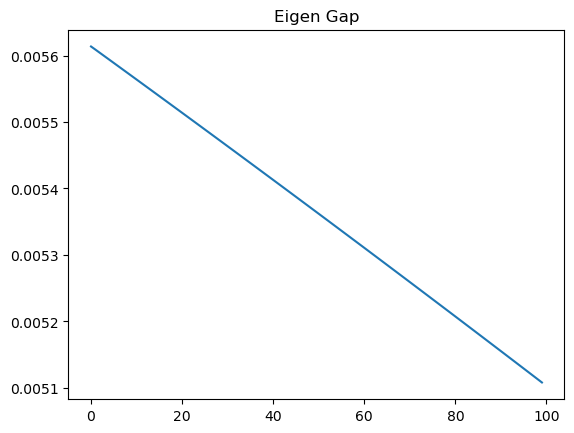

===== Individual acc_score | nmi | ari =====
K_GS_8: 0.5957(acc); 0.0122(nmi); 0.0243(ari) | weight: 0.3677
K_WL_1: 0.5532(acc); 0.1263(nmi); 0.1672(ari) | weight: 0.3379
K_RW_0.1: 0.5426(acc); 0.4301(nmi); 0.4753(ari) | weight: 0.2944
===== Joint kernel =====


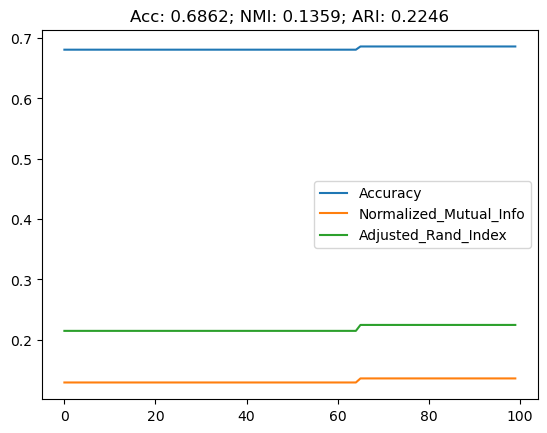

In [165]:
k_name = ["K_GS_8", "K_WL_1", "K_RW_0.1"]
K_list = [K_dict[k] for k in k_name]
num_iter = 100
class_num = len(np.unique(y))
K_new, K_best, A_new, weights, score_dict = train_A(K_list, 'uniform', class_num, 1e-5, 1e-3, num_iter)
display_results(k_name, K_list, weights, score_dict, num_iter, class_num)

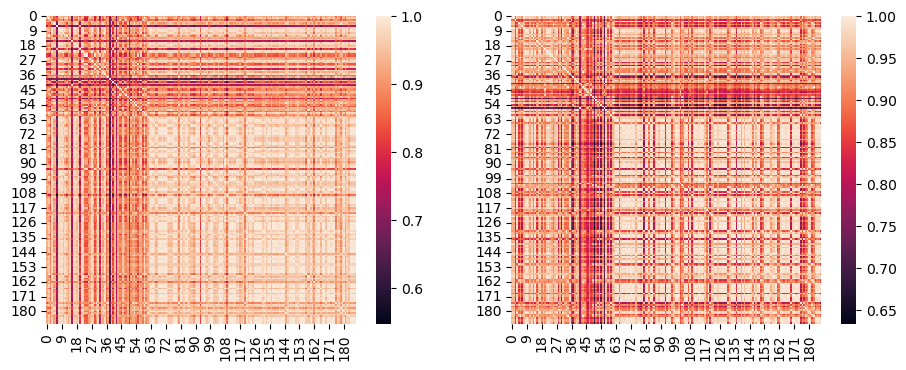

In [136]:
plt.figure(figsize=(11, 4))
plt.subplot(121)
sns.heatmap(K_new)
plt.subplot(122)
sns.heatmap(K_dict['K_WL_1'])
plt.show()

----- At No.1 iteration: sum: 1.0 norm: 0.6185-----
eigengap ratio: [0.00141476]
acc_score: 0.7978723404255319; nmi: 0.09870507937275586; ari: 0.17487069048048542

----- At No.11 iteration: sum: 1.0 norm: 0.6168-----
eigengap ratio: [0.00142131]
acc_score: 0.7978723404255319; nmi: 0.09870507937275586; ari: 0.17487069048048542

----- At No.21 iteration: sum: 1.0 norm: 0.6153-----
eigengap ratio: [0.0014321]
acc_score: 0.7978723404255319; nmi: 0.09870507937275586; ari: 0.17487069048048542

----- At No.31 iteration: sum: 1.0 norm: 0.6139-----
eigengap ratio: [0.00144698]
acc_score: 0.824468085106383; nmi: 0.1475539867860813; ari: 0.22302171982549107

----- At No.41 iteration: sum: 1.0 norm: 0.6126-----
eigengap ratio: [0.0014657]
acc_score: 0.824468085106383; nmi: 0.1475539867860813; ari: 0.22302171982549107

----- At No.51 iteration: sum: 1.0 norm: 0.6114-----
eigengap ratio: [0.00148798]
acc_score: 0.8297872340425532; nmi: 0.13784960147580697; ari: 0.2105203146988204

----- At No.61 ite

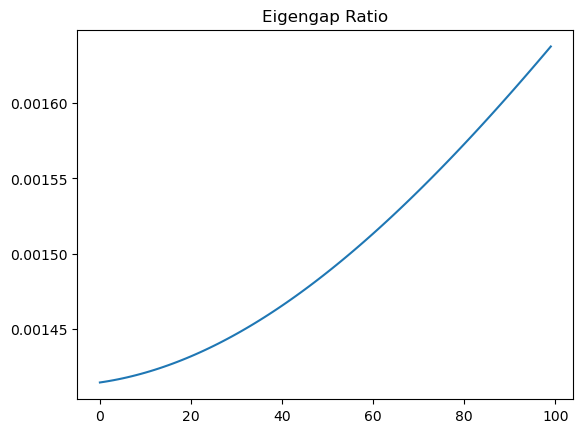

===== Individual acc_score | nmi | ari =====
K_GS_8: 0.5957(acc); 0.0122(nmi); 0.0243(ari) | weight: 0.3834
K_WL_1: 0.5532(acc); 0.1263(nmi); 0.1672(ari) | weight: 0.1829
K_RW_0.1: 0.5426(acc); 0.4301(nmi); 0.4753(ari) | weight: 0.4337
===== Joint kernel =====


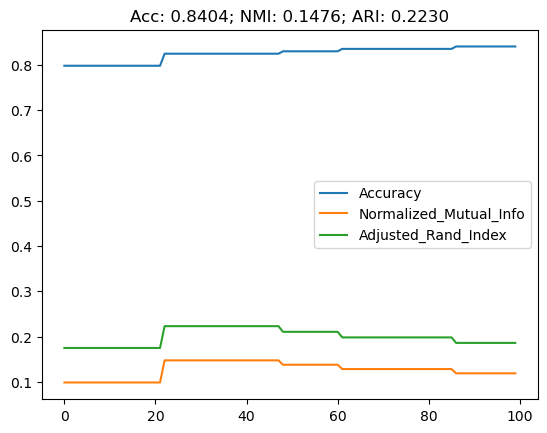

In [86]:
k_name = ["K_GS_8", "K_WL_1", "K_RW_0.1"]
K_list = [K_dict[k] for k in k_name]
num_iter = 100
class_num = len(np.unique(y))
K_new, K_best, A_new, weights, score_dict = train_A(K_list, 'eigen_inv', class_num, 4e-6, 0, num_iter)
display_results(k_name, K_list, weights, score_dict, num_iter, class_num)

----- No.1 iteration: 14.0125(g norm) 1.0(w sum) 0.2242(w norm)-----
eigengap ratio: [0.05218702]
acc_score: 0.5851063829787234; nmi: 0.17666774146146513; ari: 0.24412005918591528

----- No.11 iteration: 13.9096(g norm) 1.0(w sum) 0.2776(w norm)-----
eigengap ratio: [0.07512753]
acc_score: 0.5691489361702128; nmi: 0.17535270896623112; ari: 0.23430258577904176

----- No.21 iteration: 10.8141(g norm) 1.0(w sum) 0.316(w norm)-----
eigengap ratio: [0.08330618]
acc_score: 0.5691489361702128; nmi: 0.17535270896623112; ari: 0.23430258577904176

----- No.31 iteration: 8.2594(g norm) 1.0(w sum) 0.3497(w norm)-----
eigengap ratio: [0.08906756]
acc_score: 0.5691489361702128; nmi: 0.17535270896623112; ari: 0.23430258577904176

----- No.41 iteration: 6.8766(g norm) 1.0(w sum) 0.3674(w norm)-----
eigengap ratio: [0.09246821]
acc_score: 0.5691489361702128; nmi: 0.17535270896623112; ari: 0.23430258577904176

----- No.51 iteration: 6.107(g norm) 1.0(w sum) 0.3774(w norm)-----
eigengap ratio: [0.0942348

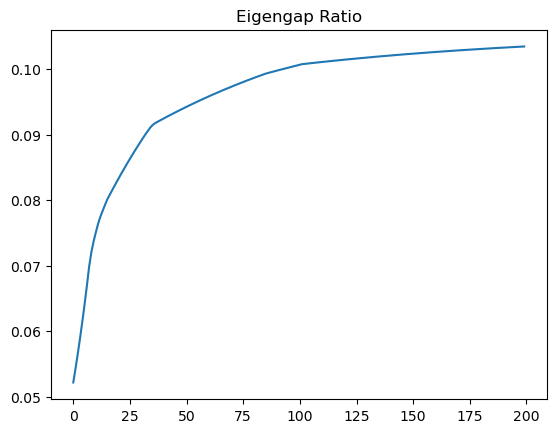

===== Individual acc_score | nmi | ari =====
K_PM_4_6: 0.7287(acc); 0.3259(nmi); 0.4489(ari) | weight: 0.0000
K_PM_5_6: 0.7287(acc); 0.3259(nmi); 0.4489(ari) | weight: 0.0000
K_PM_6_6: 0.7287(acc); 0.3259(nmi); 0.4489(ari) | weight: 0.0885
K_PM_4_7: 0.7234(acc); 0.3393(nmi); 0.4645(ari) | weight: 0.0000
K_PM_4_8: 0.7234(acc); 0.3393(nmi); 0.4645(ari) | weight: 0.0000
K_PM_4_9: 0.7234(acc); 0.3393(nmi); 0.4645(ari) | weight: 0.0000
K_VH: 0.6330(acc); 0.0691(nmi); 0.1202(ari) | weight: 0.0000
K_NH_3_8: 0.5691(acc); 0.1754(nmi); 0.2343(ari) | weight: 0.3437
K_NH_2_8: 0.5851(acc); 0.1949(nmi); 0.2660(ari) | weight: 0.1903
K_NH_1_8: 0.5691(acc); 0.1754(nmi); 0.2343(ari) | weight: 0.1211
K_NH_1_4: 0.5798(acc); 0.1882(nmi); 0.2552(ari) | weight: 0.1085
K_NH_1_6: 0.5585(acc); 0.1633(nmi); 0.2142(ari) | weight: 0.0957
K_WL_1: 0.5532(acc); 0.1263(nmi); 0.1672(ari) | weight: 0.0000
K_GS_8: 0.5957(acc); 0.0122(nmi); 0.0243(ari) | weight: 0.0000
K_SP: 0.6755(acc); 0.2106(nmi); 0.3180(ari) | weight:

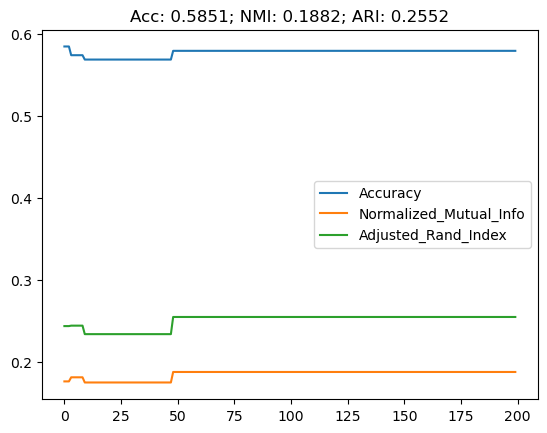

In [97]:
k_name = list(K_dict.keys())#["K_GS_8", "K_NH_1_8", "K_WL_7", "K_WL_1", "K_RW_0.1"]
K_list = [K_dict[k] for k in k_name]
num_iter = 200
class_num = len(np.unique(y))
K_new, K_best, A_new, weights, score_dict = train_A(K_list, 'uniform', class_num, 5e-3, 0, num_iter)
display_results(k_name, K_list, weights, score_dict, num_iter, class_num)

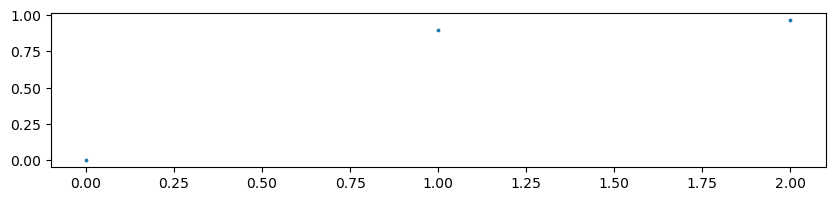

In [177]:
i = 0#4
L = csgraph.laplacian(K_list[i], normed=True)
eigenValues, eigenVectors = scipy.linalg.eigh(L, subset_by_index=[0,2])
eigenValues
plt.figure(figsize = (10,2))
plt.scatter(np.arange(len(eigenValues)), eigenValues, s = 3)
# plt.title(f"{eigenValues[:4]}\n{k_name[i]} Gap: {(eigenValues[2]-eigenValues[1])/eigenValues[1]}")
plt.show()

# All kernels

In [50]:
eigen_weights_list = []
K_list = list(K_dict.values())
for K_train in K_list:
    eigenValues, eigenV_kp1, eigenV = cal_Lap_eigen(K_train, 2)
    eigen_gap = np.diff(eigenValues)
    eigen_weights_list.append(eigen_gap)
print(dict(zip(list(K_dict.keys()), eigen_weights_list)))

{'K_PM_4_6': array([0.06562209]), 'K_PM_5_6': array([0.07453362]), 'K_PM_6_6': array([0.07941353]), 'K_PM_4_7': array([0.06495917]), 'K_PM_4_8': array([0.0646363]), 'K_PM_4_9': array([0.06327523]), 'K_VH': array([0.01964708]), 'K_NH_3_8': array([0.09276063]), 'K_NH_2_8': array([0.08535553]), 'K_NH_1_8': array([0.09026642]), 'K_NH_1_4': array([0.08905231]), 'K_NH_1_6': array([0.090502]), 'K_WL_1': array([0.03373604]), 'K_WL_3': array([0.05056452]), 'K_WL_5': array([0.04946269]), 'K_WL_7': array([0.04837865]), 'K_WL_9': array([0.04800426]), 'K_WL_11': array([0.04791111]), 'K_GS_4': array([0.00100205]), 'K_GS_5': array([0.00320956]), 'K_GS_6': array([0.00346908]), 'K_GS_7': array([0.01040226]), 'K_SP': array([0.07067544])}


In [91]:
def plot_eigens(K, class_num):
    L = csgraph.laplacian(K, normed=True)
    eigenValues, eigenVectors = scipy.linalg.eigh(L, subset_by_index=[0, class_num])
    assert (len(eigenValues) == (class_num + 1))
    plt.figure(figsize = (3,2))
    plt.plot(np.arange(class_num+1), eigenValues)
    plt.title(f'[k, k+1]: {eigenValues[-2:]}\n{(eigenValues[-1]-eigenValues[-2])/eigenValues[-2]}')
    plt.plot()


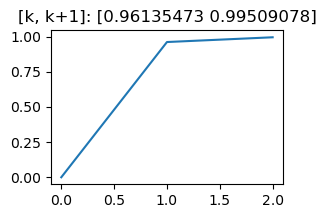

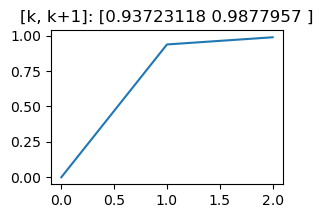

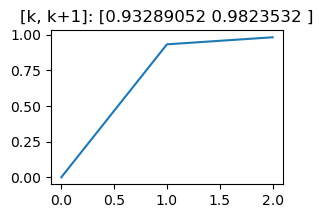

In [74]:
plot_eigens(K_dict['K_WL_1'], len(np.unique(y_adj)))
plot_eigens(K_dict['K_WL_3'], len(np.unique(y_adj)))
plot_eigens(K_dict['K_WL_5'], len(np.unique(y_adj)))

## Uniform init

----- At No.1 iteration: sum: 1.0 norm: 0.2-----
eigengap ratio: [0.04271997]
acc_score: 0.5851063829787234; nmi: 0.17666774146146513

----- At No.11 iteration: sum: 1.0 norm: 0.2013-----
eigengap ratio: [0.04573046]
acc_score: 0.5851063829787234; nmi: 0.17666774146146513

----- At No.21 iteration: sum: 1.0 norm: 0.2046-----
eigengap ratio: [0.0489146]
acc_score: 0.5851063829787234; nmi: 0.17666774146146513

----- At No.31 iteration: sum: 1.0 norm: 0.2098-----
eigengap ratio: [0.05228715]
acc_score: 0.5851063829787234; nmi: 0.17666774146146513

----- At No.41 iteration: sum: 1.0 norm: 0.2168-----
eigengap ratio: [0.05586807]
acc_score: 0.5851063829787234; nmi: 0.17666774146146513

----- At No.51 iteration: sum: 1.0 norm: 0.2252-----
eigengap ratio: [0.05968298]
acc_score: 0.574468085106383; nmi: 0.18165729852067422

----- At No.61 iteration: sum: 1.0 norm: 0.2351-----
eigengap ratio: [0.06376413]
acc_score: 0.574468085106383; nmi: 0.18165729852067422

----- At No.71 iteration: sum: 1.0

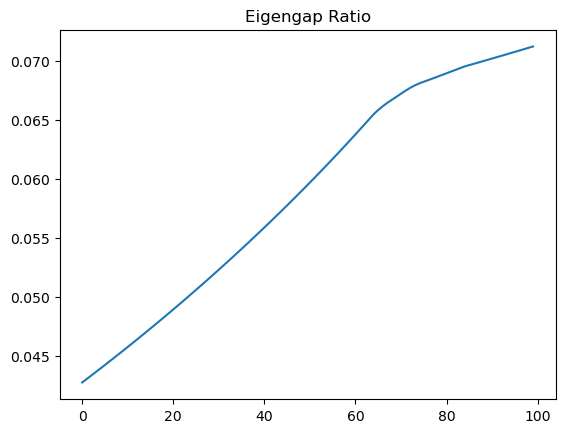

Final weights: [0.0362389  0.05316623 0.07417726 0.03713378 0.0377865  0.03808058
 0.         0.10764196 0.08797203 0.07848112 0.0760283  0.07840722
 0.         0.01419934 0.03724339 0.05517071 0.06910624 0.08031161
 0.00601299 0.03090558 0.         0.         0.         0.
 0.00193627]
===== Individual acc_score | nmi=====
K_PM_4_6: 0.7287(acc); 0.3259(nmi) | weight: 0.0362
K_PM_5_6: 0.7287(acc); 0.3259(nmi) | weight: 0.0532
K_PM_6_6: 0.7287(acc); 0.3259(nmi) | weight: 0.0742
K_PM_4_7: 0.7234(acc); 0.3393(nmi) | weight: 0.0371
K_PM_4_8: 0.7234(acc); 0.3393(nmi) | weight: 0.0378
K_PM_4_9: 0.7234(acc); 0.3393(nmi) | weight: 0.0381
K_VH: 0.6330(acc); 0.0691(nmi) | weight: 0.0000
K_NH_3_8: 0.5691(acc); 0.1754(nmi) | weight: 0.1076
K_NH_2_8: 0.5798(acc); 0.1882(nmi) | weight: 0.0880
K_NH_1_8: 0.5691(acc); 0.1754(nmi) | weight: 0.0785
K_NH_1_4: 0.5691(acc); 0.1754(nmi) | weight: 0.0760
K_NH_1_6: 0.5691(acc); 0.1754(nmi) | weight: 0.0784
K_WL_1: 0.5532(acc); 0.1263(nmi) | weight: 0.0000
K_WL

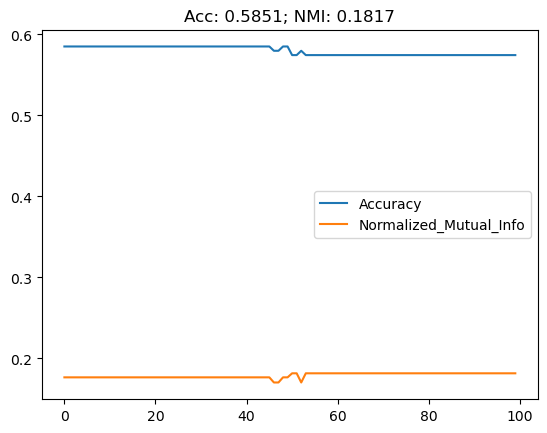

In [76]:
K_list = list(K_dict.values())
num_iter = 100
K_new, weights, score_dict = train(K_list, 'uniform', 2, 5e-4, num_iter)
print("Final weights:", weights)
display_results(list(K_dict.keys()), K_list, weights, score_dict, num_iter)

## Eigen init

----- At No.1 iteration: sum: 1.0 norm: 0.2372-----
eigengap ratio: [0.06602243]
acc_score: 0.574468085106383; nmi: 0.18165729852067422

----- At No.11 iteration: sum: 1.0 norm: 0.2392-----
eigengap ratio: [0.06703552]
acc_score: 0.574468085106383; nmi: 0.18165729852067422

----- At No.21 iteration: sum: 1.0 norm: 0.2408-----
eigengap ratio: [0.06784602]
acc_score: 0.574468085106383; nmi: 0.18165729852067422

----- At No.31 iteration: sum: 1.0 norm: 0.242-----
eigengap ratio: [0.06844439]
acc_score: 0.574468085106383; nmi: 0.18165729852067422

----- At No.41 iteration: sum: 1.0 norm: 0.2434-----
eigengap ratio: [0.06904669]
acc_score: 0.574468085106383; nmi: 0.18165729852067422

----- At No.51 iteration: sum: 1.0 norm: 0.2447-----
eigengap ratio: [0.06965303]
acc_score: 0.574468085106383; nmi: 0.18165729852067422

----- At No.61 iteration: sum: 1.0 norm: 0.2459-----
eigengap ratio: [0.07014059]
acc_score: 0.574468085106383; nmi: 0.18165729852067422

----- At No.71 iteration: sum: 1.0 n

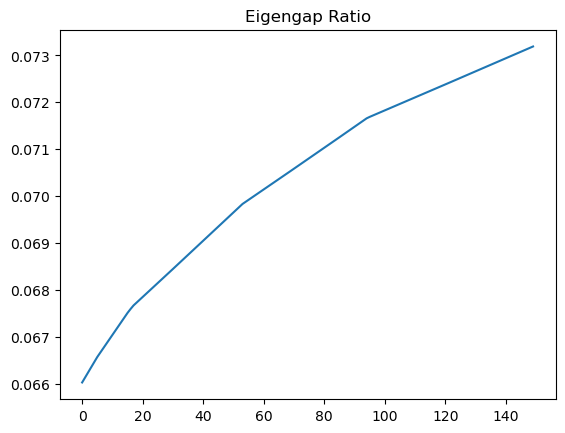

Final weights: [0.04797179 0.06144445 0.07320892 0.04777395 0.04775853 0.04677667
 0.         0.09643894 0.08315635 0.08355086 0.08165879 0.08371228
 0.00515805 0.02766654 0.03539434 0.04122322 0.0461293  0.05024079
 0.         0.         0.         0.         0.04073622]
===== Individual acc_score | nmi=====
K_PM_4_6: 0.7287(acc); 0.3259(nmi) | weight: 0.0480
K_PM_5_6: 0.7287(acc); 0.3259(nmi) | weight: 0.0614
K_PM_6_6: 0.7287(acc); 0.3259(nmi) | weight: 0.0732
K_PM_4_7: 0.7234(acc); 0.3393(nmi) | weight: 0.0478
K_PM_4_8: 0.7234(acc); 0.3393(nmi) | weight: 0.0478
K_PM_4_9: 0.7234(acc); 0.3393(nmi) | weight: 0.0468
K_VH: 0.6330(acc); 0.0691(nmi) | weight: 0.0000
K_NH_3_8: 0.5691(acc); 0.1754(nmi) | weight: 0.0964
K_NH_2_8: 0.5798(acc); 0.1882(nmi) | weight: 0.0832
K_NH_1_8: 0.5691(acc); 0.1754(nmi) | weight: 0.0836
K_NH_1_4: 0.5691(acc); 0.1754(nmi) | weight: 0.0817
K_NH_1_6: 0.5691(acc); 0.1754(nmi) | weight: 0.0837
K_WL_1: 0.5532(acc); 0.1263(nmi) | weight: 0.0052
K_WL_3: 0.5372(acc)

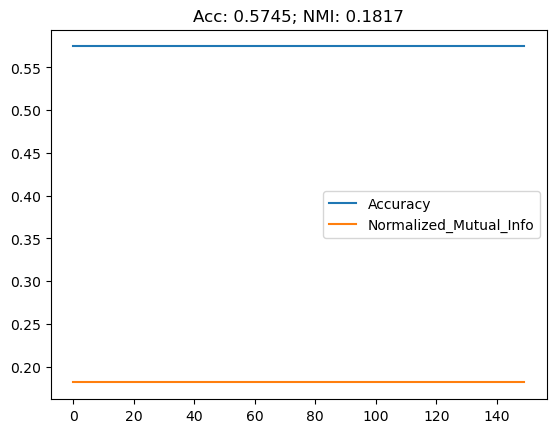

In [51]:
K_list = list(K_dict.values())
num_iter = 150
K_new, weights, score_dict = train(K_list, 'eigen', 2, 1e-4, num_iter)
print("Final weights:", weights)
display_results(list(K_dict.keys()), K_list, weights, score_dict, num_iter)

[array([0.03373604]), array([0.05056452]), array([0.04946269]), array([0.04837865]), array([0.04800426]), array([0.04791111]), array([0.04783052]), array([0.00100205]), array([0.00320956]), array([0.00346908]), array([0.01040226]), array([0.01738413]), array([0.07717295]), array([0.07067544]), array([0.07067544]), array([0.07067544]), array([0.00491995]), array([0.01140713]), array([0.01800665]), array([0.02436504]), array([0.03051495]), array([0.03651686])]
----- At No.1 iteration: sum: 1.0 norm: 0.2133-----
eigengap ratio: [0.02312539]
acc_score: 0.601063829787234; nmi: 0.16131167682035114

----- At No.11 iteration: sum: 1.0 norm: 0.2149-----
eigengap ratio: [0.02485543]
acc_score: 0.574468085106383; nmi: 0.18165729852067422

----- At No.21 iteration: sum: 1.0 norm: 0.2196-----
eigengap ratio: [0.02660481]
acc_score: 0.574468085106383; nmi: 0.18165729852067422

----- At No.31 iteration: sum: 1.0 norm: 0.2269-----
eigengap ratio: [0.02836643]
acc_score: 0.5797872340425532; nmi: 0.1881

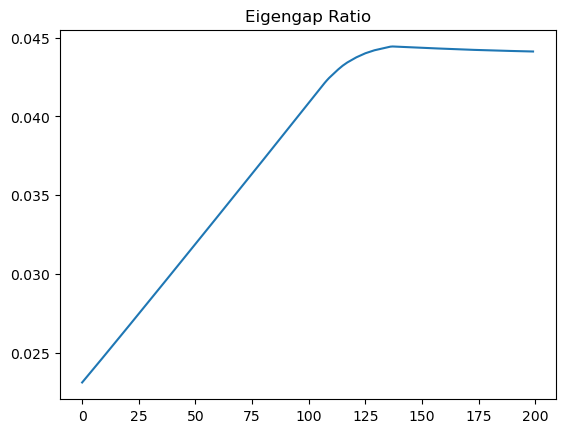

Final weights: [0.         0.04152369 0.09395317 0.1347778  0.16649202 0.19198378
 0.21297415 0.         0.         0.         0.         0.01572158
 0.07755953 0.02167142 0.02167142 0.02167142 0.         0.
 0.         0.         0.         0.        ]
===== Individual acc_score | nmi=====
K_WL_1: 0.5531914893617021(acc); 0.12630262331970238(nmi) | weight: 0.0
K_WL_3: 0.5372340425531915(acc); 0.14117330695269498(nmi) | weight: 0.041523685785528924
K_WL_5: 0.5478723404255319(acc); 0.13613838486956323(nmi) | weight: 0.09395317481811906
K_WL_7: 0.5531914893617021(acc); 0.1414230072157862(nmi) | weight: 0.13477779924822186
K_WL_9: 0.5531914893617021(acc); 0.1414230072157862(nmi) | weight: 0.16649201968566743
K_WL_11: 0.5531914893617021(acc); 0.1414230072157862(nmi) | weight: 0.19198378405573022
K_WL_13: 0.5531914893617021(acc); 0.1414230072157862(nmi) | weight: 0.21297415380847728
K_GS_4: 0.7712765957446809(acc); 0.14275263914692107(nmi) | weight: 0.0
K_GS_5: 0.5851063829787234(acc); 0.05

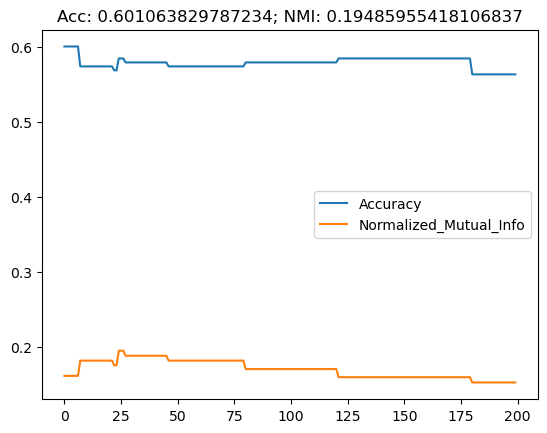

In [66]:
K_list = list(K_dict.values())
num_iter = 200
K_new, weights, score_dict = train(K_list, 'eigen-inv', 2, 1e-4, num_iter)
print("Final weights:", weights)
display_results(list(K_dict.keys()), K_list, weights, score_dict, num_iter)

## Random init

----- At No.1 iteration: sum: 1.0 norm: 0.2669-----
eigengap ratio: [0.02607541]
acc_score: 0.574468085106383; nmi: 0.18165729852067422

----- At No.11 iteration: sum: 1.0 norm: 0.2678-----
eigengap ratio: [0.02708382]
acc_score: 0.574468085106383; nmi: 0.18165729852067422

----- At No.21 iteration: sum: 1.0 norm: 0.2694-----
eigengap ratio: [0.02807886]
acc_score: 0.574468085106383; nmi: 0.18165729852067422

----- At No.31 iteration: sum: 1.0 norm: 0.2713-----
eigengap ratio: [0.02903667]
acc_score: 0.5851063829787234; nmi: 0.19485955418106837

----- At No.41 iteration: sum: 1.0 norm: 0.2739-----
eigengap ratio: [0.03000332]
acc_score: 0.5851063829787234; nmi: 0.19485955418106837

----- At No.51 iteration: sum: 1.0 norm: 0.2772-----
eigengap ratio: [0.03098172]
acc_score: 0.5797872340425532; nmi: 0.1881565335237106

----- At No.61 iteration: sum: 1.0 norm: 0.2805-----
eigengap ratio: [0.03188872]
acc_score: 0.5797872340425532; nmi: 0.1881565335237106

----- At No.71 iteration: sum: 1.

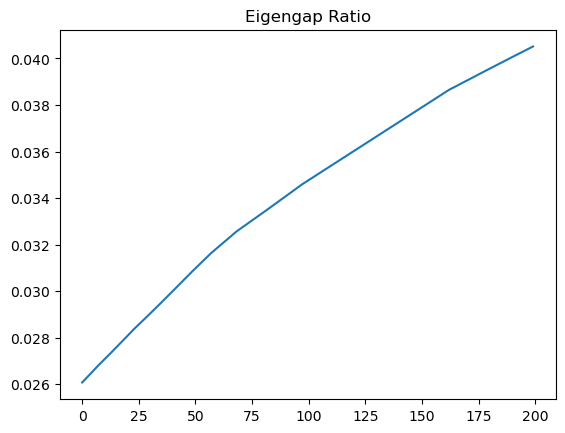

Final weights: [0.         0.02602282 0.17566081 0.08782538 0.12280588 0.15943276
 0.17294249 0.         0.         0.02783306 0.         0.00318878
 0.07351355 0.04107612 0.02021162 0.01998578 0.         0.04349139
 0.         0.         0.         0.02600957]
===== Individual acc_score | nmi=====
K_WL_1: 0.5531914893617021(acc); 0.12630262331970238(nmi) | weight: 0.0
K_WL_3: 0.5372340425531915(acc); 0.14117330695269498(nmi) | weight: 0.02602282314259281
K_WL_5: 0.5478723404255319(acc); 0.13613838486956323(nmi) | weight: 0.17566080683146956
K_WL_7: 0.5531914893617021(acc); 0.1414230072157862(nmi) | weight: 0.08782537513892283
K_WL_9: 0.5531914893617021(acc); 0.1414230072157862(nmi) | weight: 0.12280587878238404
K_WL_11: 0.5531914893617021(acc); 0.1414230072157862(nmi) | weight: 0.15943275825693648
K_WL_13: 0.5531914893617021(acc); 0.1414230072157862(nmi) | weight: 0.17294249118407423
K_GS_4: 0.7712765957446809(acc); 0.14275263914692107(nmi) | weight: 0.0
K_GS_5: 0.5851063829787234(acc

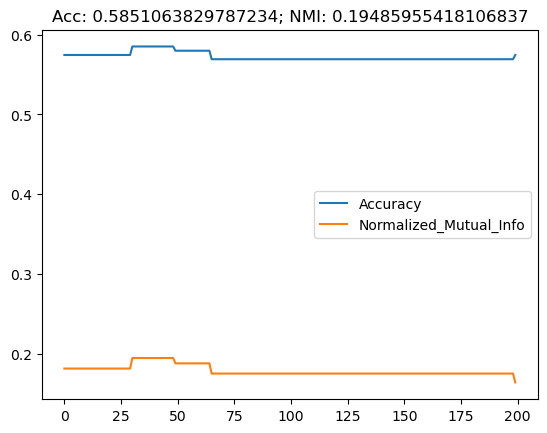

In [68]:
K_list = list(K_dict.values())
num_iter = 200
K_new, weights, score_dict = train(K_list, 'random', 2, 1e-4, 200)
print("Final weights:", weights)
display_results(list(K_dict.keys()), K_list, weights, score_dict, 200)

# Kernels with the same type

## Uniform init

----- At No.1 iteration: sum: 1.0 norm: 0.4036-----
eigengap ratio: [0.05284909]
acc_score: 0.5531914893617021; nmi: 0.1414230072157862

----- At No.11 iteration: sum: 1.0 norm: 0.4026-----
eigengap ratio: [0.05279563]
acc_score: 0.5531914893617021; nmi: 0.1414230072157862

----- At No.21 iteration: sum: 1.0 norm: 0.4016-----
eigengap ratio: [0.05273713]
acc_score: 0.5531914893617021; nmi: 0.1414230072157862

----- At No.31 iteration: sum: 1.0 norm: 0.4005-----
eigengap ratio: [0.05267327]
acc_score: 0.5531914893617021; nmi: 0.1414230072157862

----- At No.41 iteration: sum: 1.0 norm: 0.3995-----
eigengap ratio: [0.05260373]
acc_score: 0.5531914893617021; nmi: 0.1414230072157862

----- At No.51 iteration: sum: 1.0 norm: 0.3986-----
eigengap ratio: [0.05252824]
acc_score: 0.5531914893617021; nmi: 0.1414230072157862

----- At No.61 iteration: sum: 1.0 norm: 0.3977-----
eigengap ratio: [0.05244657]
acc_score: 0.5531914893617021; nmi: 0.1414230072157862

----- At No.71 iteration: sum: 1.0 

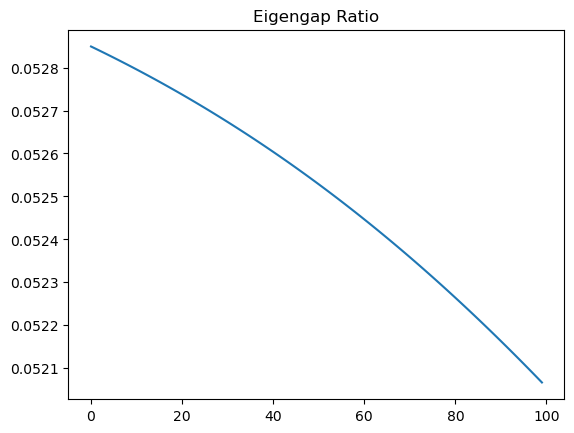

Final weights: [0.09851339 0.18778437 0.14897643 0.17247249 0.06925928 0.19778436
 0.12520969]
===== Individual acc_score | nmi=====
K_WL_1: 0.5532(acc); 0.1263(nmi) | weight: 0.0985
K_WL_3: 0.5372(acc); 0.1412(nmi) | weight: 0.1878
K_WL_5: 0.5479(acc); 0.1361(nmi) | weight: 0.1490
K_WL_7: 0.5532(acc); 0.1414(nmi) | weight: 0.1725
K_WL_9: 0.5532(acc); 0.1414(nmi) | weight: 0.0693
K_WL_11: 0.5532(acc); 0.1414(nmi) | weight: 0.1978
K_WL_13: 0.5532(acc); 0.1414(nmi) | weight: 0.1252
===== Joint kernel =====


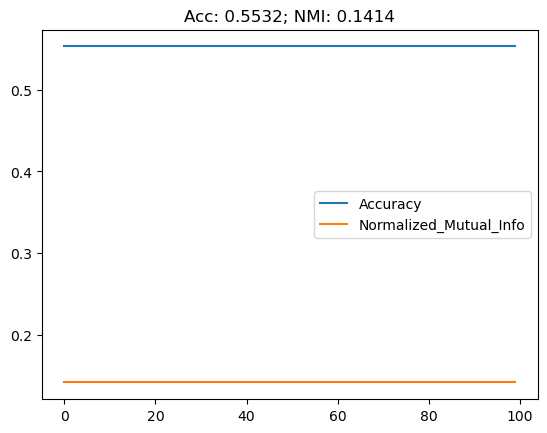

In [112]:
K_list = [K_dict[k] for k in K_dict.keys() if k.startswith("K_WL")]
kernel_name = [k for k in K_dict.keys() if k.startswith("K_WL")]
num_iter = 100

K_new, weights, score_dict = train(K_list, 'random', 2, 1e-3, num_iter)
print("Final weights:", weights)
display_results(kernel_name, K_list, weights, score_dict, num_iter)

----- At No.1 iteration: sum: 1.0 norm: 0.6526-----
eigengap ratio: [0.00486578]
acc_score: 0.5797872340425532; nmi: 0.004896519004286707

----- At No.11 iteration: sum: 1.0 norm: 0.8456-----
eigengap ratio: [0.07167511]
acc_score: 0.8670212765957447; nmi: 0.19408829044872525

----- At No.21 iteration: sum: 1.0 norm: 0.9329-----
eigengap ratio: [0.08287127]
acc_score: 0.8723404255319149; nmi: 0.1830676965843314

----- At No.31 iteration: sum: 1.0 norm: 1.0-----
eigengap ratio: [0.09027952]
acc_score: 0.8723404255319149; nmi: 0.1830676965843314

----- At No.41 iteration: sum: 1.0 norm: 1.0-----
eigengap ratio: [0.09062258]
acc_score: 0.8723404255319149; nmi: 0.1830676965843314



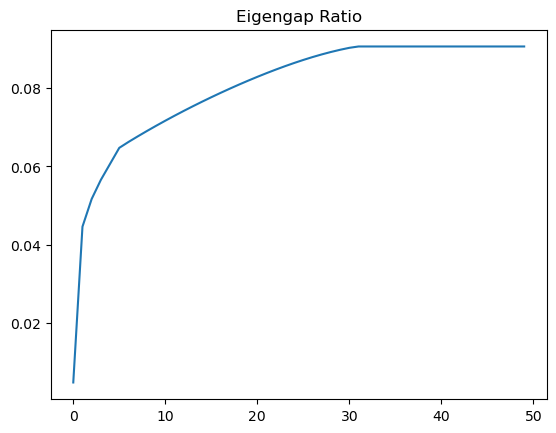

Final weights: [0. 0. 0. 0. 0. 1.]
===== Individual acc_score | nmi=====
K_GS_4: 0.7712765957446809(acc); 0.14275263914692107(nmi) | weight: 0.0
K_GS_5: 0.5851063829787234(acc); 0.05575607792923468(nmi) | weight: 0.0
K_GS_6: 0.7553191489361702(acc); 0.08737371961034919(nmi) | weight: 0.0
K_GS_7: 0.6170212765957447(acc); 0.014077249308283699(nmi) | weight: 0.0
K_GS_8: 0.5957446808510638(acc); 0.01220624712783504(nmi) | weight: 0.0
K_GS_9: 0.8723404255319149(acc); 0.1830676965843314(nmi) | weight: 1.0
===== Joint kernel =====


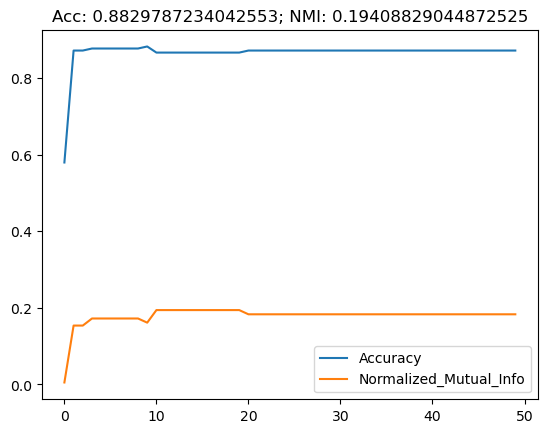

In [72]:
K_list = [K_dict[k] for k in K_dict.keys() if k.startswith("K_GS")]
kernel_name = [k for k in K_dict.keys() if k.startswith("K_GS")]
num_iter = 50

K_new, weights, score_dict = train(K_list, 'random', 2, 1e-2, num_iter)
print("Final weights:", weights)
display_results(kernel_name, K_list, weights, score_dict, num_iter)

----- At No.1 iteration: sum: 1.0 norm: 0.4082-----
eigengap ratio: [0.02108788]
acc_score: 0.5159574468085106; nmi: 0.32466786046867857

----- At No.11 iteration: sum: 1.0 norm: 0.4082-----
eigengap ratio: [0.02109411]
acc_score: 0.5159574468085106; nmi: 0.32466786046867857

----- At No.21 iteration: sum: 1.0 norm: 0.4082-----
eigengap ratio: [0.02110035]
acc_score: 0.5159574468085106; nmi: 0.32466786046867857

----- At No.31 iteration: sum: 1.0 norm: 0.4082-----
eigengap ratio: [0.02110658]
acc_score: 0.5159574468085106; nmi: 0.32466786046867857

----- At No.41 iteration: sum: 1.0 norm: 0.4082-----
eigengap ratio: [0.02111282]
acc_score: 0.5159574468085106; nmi: 0.32466786046867857

----- At No.51 iteration: sum: 1.0 norm: 0.4082-----
eigengap ratio: [0.02111905]
acc_score: 0.5159574468085106; nmi: 0.32466786046867857

----- At No.61 iteration: sum: 1.0 norm: 0.4083-----
eigengap ratio: [0.02112529]
acc_score: 0.5159574468085106; nmi: 0.32466786046867857

----- At No.71 iteration: su

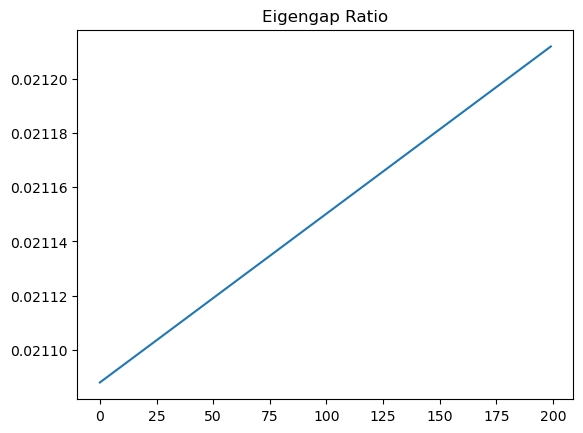

Final weights: [0.16391992 0.16503288 0.16616569 0.1672539  0.16830334 0.16932428]
===== Individual acc_score | nmi=====
K_RW_0.5: 0.5106382978723404(acc); 0.3455467666433281(nmi) | weight: 0.163919923891533
K_RW_1.0: 0.5159574468085106(acc); 0.32466786046867857(nmi) | weight: 0.1650328766331535
K_RW_1.5: 0.5159574468085106(acc); 0.32466786046867857(nmi) | weight: 0.16616568529879938
K_RW_2.0: 0.5159574468085106(acc); 0.32466786046867857(nmi) | weight: 0.16725389969455912
K_RW_2.5: 0.5159574468085106(acc); 0.32466786046867857(nmi) | weight: 0.16830333658689606
K_RW_3.0: 0.5159574468085106(acc); 0.32466786046867857(nmi) | weight: 0.16932427789505897
===== Joint kernel =====


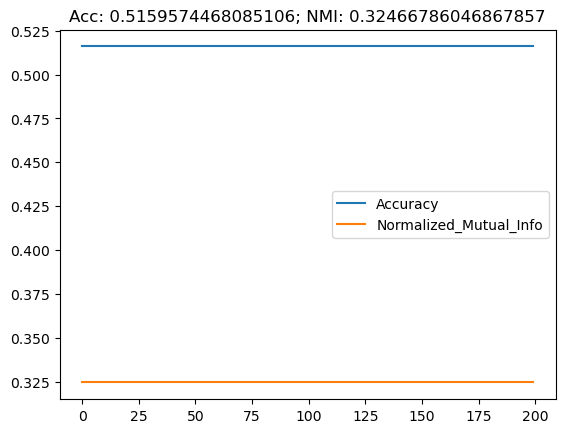

In [84]:
K_list = [K_dict[k] for k in K_dict.keys() if k.startswith("K_RW")]
kernel_name = [k for k in K_dict.keys() if k.startswith("K_RW")]
num_iter = 200

K_new, weights, score_dict = train(K_list, 'uniform', 2, 1e-3, num_iter)
print("Final weights:", weights)
display_results(kernel_name, K_list, weights, score_dict, num_iter)

## Eigen init

----- At No.1 iteration: sum: 1.0 norm: 0.378-----
eigengap ratio: [0.05085671]
acc_score: 0.5531914893617021; nmi: 0.1414230072157862

----- At No.11 iteration: sum: 1.0 norm: 0.3784-----
eigengap ratio: [0.05072341]
acc_score: 0.5531914893617021; nmi: 0.1414230072157862

----- At No.21 iteration: sum: 1.0 norm: 0.3792-----
eigengap ratio: [0.05058326]
acc_score: 0.5531914893617021; nmi: 0.1414230072157862

----- At No.31 iteration: sum: 1.0 norm: 0.3803-----
eigengap ratio: [0.05043707]
acc_score: 0.5531914893617021; nmi: 0.1414230072157862

----- At No.41 iteration: sum: 1.0 norm: 0.382-----
eigengap ratio: [0.05028583]
acc_score: 0.5531914893617021; nmi: 0.1414230072157862

----- At No.51 iteration: sum: 1.0 norm: 0.384-----
eigengap ratio: [0.05013062]
acc_score: 0.5531914893617021; nmi: 0.1414230072157862

----- At No.61 iteration: sum: 1.0 norm: 0.3865-----
eigengap ratio: [0.04997255]
acc_score: 0.5478723404255319; nmi: 0.13613838486956323

----- At No.71 iteration: sum: 1.0 no

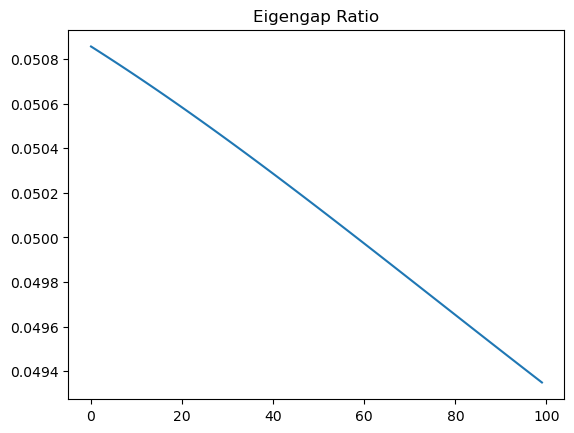

Final weights: [0.23136911 0.18864869 0.15656988 0.13171379 0.11214521 0.09629987
 0.08325346]
===== Individual acc_score | nmi=====
K_WL_1: 0.5532(acc); 0.1263(nmi) | weight: 0.2314
K_WL_3: 0.5372(acc); 0.1412(nmi) | weight: 0.1886
K_WL_5: 0.5479(acc); 0.1361(nmi) | weight: 0.1566
K_WL_7: 0.5532(acc); 0.1414(nmi) | weight: 0.1317
K_WL_9: 0.5532(acc); 0.1414(nmi) | weight: 0.1121
K_WL_11: 0.5532(acc); 0.1414(nmi) | weight: 0.0963
K_WL_13: 0.5532(acc); 0.1414(nmi) | weight: 0.0833
===== Joint kernel =====


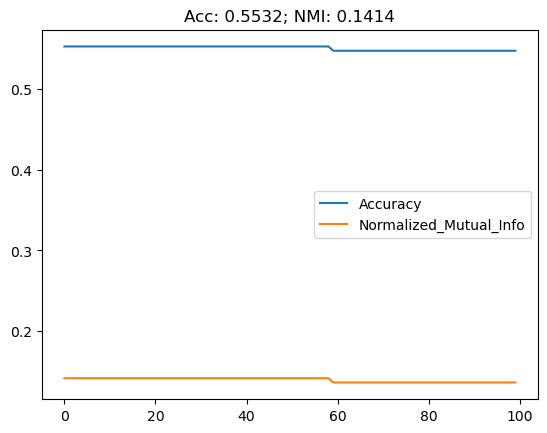

In [115]:
K_list = [K_dict[k] for k in K_dict.keys() if k.startswith("K_WL")]
kernel_name = [k for k in K_dict.keys() if k.startswith("K_WL")]
num_iter = 100

K_new, weights, score_dict = train(K_list, 'eigen_inv', 2, 1e-3, num_iter)
print("Final weights:", weights)
display_results(kernel_name, K_list, weights, score_dict, num_iter)

----- At No.1 iteration: sum: 1.0 norm: 0.7546-----
eigengap ratio: [0.05090524]
acc_score: 0.8617021276595744; nmi: 0.17486808256216899

----- At No.11 iteration: sum: 1.0 norm: 0.9056-----
eigengap ratio: [0.0794925]
acc_score: 0.8670212765957447; nmi: 0.19408829044872525

----- At No.21 iteration: sum: 1.0 norm: 0.981-----
eigengap ratio: [0.08837725]
acc_score: 0.8723404255319149; nmi: 0.1830676965843314

----- At No.31 iteration: sum: 1.0 norm: 1.0-----
eigengap ratio: [0.09062258]
acc_score: 0.8723404255319149; nmi: 0.1830676965843314

----- At No.41 iteration: sum: 1.0 norm: 1.0-----
eigengap ratio: [0.09062258]
acc_score: 0.8723404255319149; nmi: 0.1830676965843314



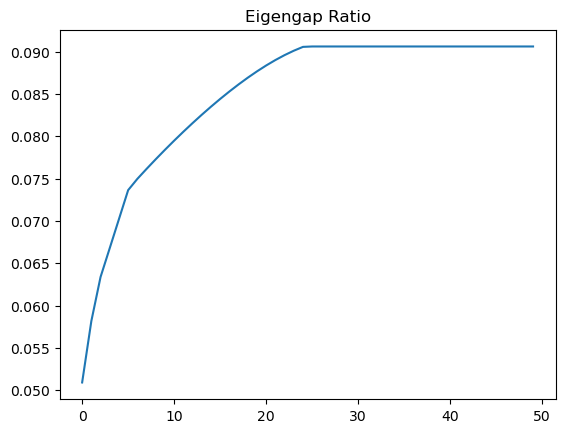

Final weights: [0. 0. 0. 0. 0. 1.]
===== Individual acc_score | nmi=====
K_GS_4: 0.7713(acc); 0.1428(nmi) | weight: 0.0000
K_GS_5: 0.5851(acc); 0.0558(nmi) | weight: 0.0000
K_GS_6: 0.7553(acc); 0.0874(nmi) | weight: 0.0000
K_GS_7: 0.6170(acc); 0.0141(nmi) | weight: 0.0000
K_GS_8: 0.5957(acc); 0.0122(nmi) | weight: 0.0000
K_GS_9: 0.8723(acc); 0.1831(nmi) | weight: 1.0000
===== Joint kernel =====


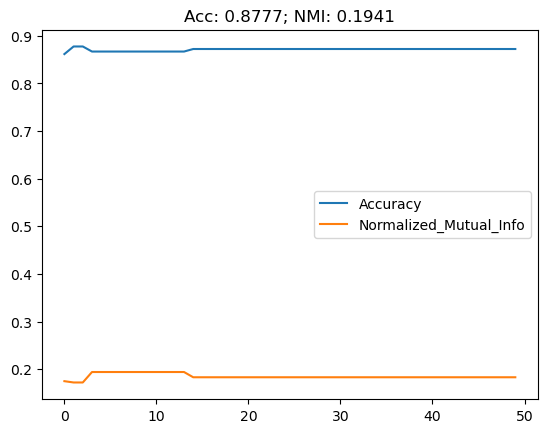

In [110]:
K_list = [K_dict[k] for k in K_dict.keys() if k.startswith("K_GS")]
kernel_name = [k for k in K_dict.keys() if k.startswith("K_GS")]
num_iter = 50

K_new, weights, score_dict = train(K_list, 'eigen', 2, 1e-2, num_iter)
print("Final weights:", weights)
display_results(kernel_name, K_list, weights, score_dict, num_iter)

----- At No.1 iteration: sum: 1.0 norm: 0.7488-----
eigengap ratio: [0.00606283]
acc_score: 0.5531914893617021; nmi: 0.0031444437769900715

----- At No.11 iteration: sum: 1.0 norm: 0.8484-----
eigengap ratio: [0.0720642]
acc_score: 0.8670212765957447; nmi: 0.19408829044872525

----- At No.21 iteration: sum: 1.0 norm: 0.9353-----
eigengap ratio: [0.08316206]
acc_score: 0.8723404255319149; nmi: 0.1830676965843314

----- At No.31 iteration: sum: 1.0 norm: 1.0-----
eigengap ratio: [0.09041832]
acc_score: 0.8723404255319149; nmi: 0.1830676965843314

----- At No.41 iteration: sum: 1.0 norm: 1.0-----
eigengap ratio: [0.09062258]
acc_score: 0.8723404255319149; nmi: 0.1830676965843314



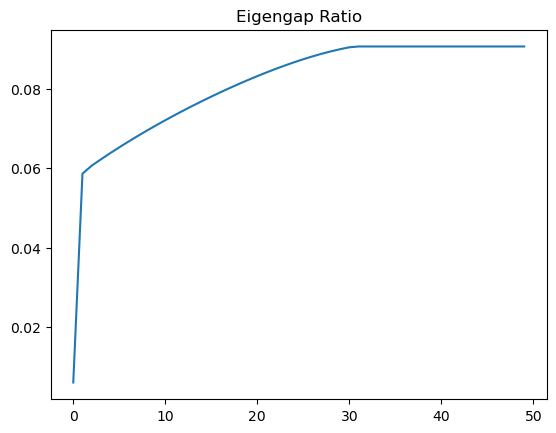

Final weights: [0. 0. 0. 0. 0. 1.]
===== Individual acc_score | nmi=====
K_GS_4: 0.7713(acc); 0.1428(nmi) | weight: 0.0000
K_GS_5: 0.5851(acc); 0.0558(nmi) | weight: 0.0000
K_GS_6: 0.7553(acc); 0.0874(nmi) | weight: 0.0000
K_GS_7: 0.6170(acc); 0.0141(nmi) | weight: 0.0000
K_GS_8: 0.5957(acc); 0.0122(nmi) | weight: 0.0000
K_GS_9: 0.8723(acc); 0.1831(nmi) | weight: 1.0000
===== Joint kernel =====


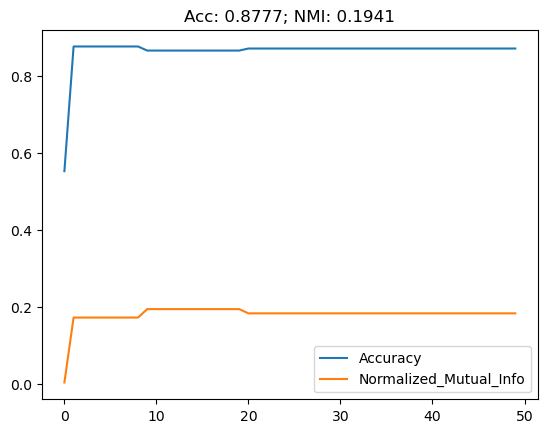

In [111]:
K_list = [K_dict[k] for k in K_dict.keys() if k.startswith("K_GS")]
kernel_name = [k for k in K_dict.keys() if k.startswith("K_GS")]
num_iter = 50

K_new, weights, score_dict = train(K_list, 'eigen_inv', 2, 1e-2, num_iter)
print("Final weights:", weights)
display_results(kernel_name, K_list, weights, score_dict, num_iter)

# Subset kernels

----- At No.1 iteration: sum: 1.0 norm: 0.2586-----
eigengap ratio: [0.01628473]
acc_score: 0.7074468085106383; nmi: 0.24869782461798254

----- At No.11 iteration: sum: 1.0 norm: 0.2588-----
eigengap ratio: [0.01744644]
acc_score: 0.7021276595744681; nmi: 0.26081158016587475

----- At No.21 iteration: sum: 1.0 norm: 0.2615-----
eigengap ratio: [0.01861233]
acc_score: 0.7180851063829787; nmi: 0.2481104625646065

----- At No.31 iteration: sum: 1.0 norm: 0.2663-----
eigengap ratio: [0.01976866]
acc_score: 0.7127659574468085; nmi: 0.2601069694306256

----- At No.41 iteration: sum: 1.0 norm: 0.2726-----
eigengap ratio: [0.02090928]
acc_score: 0.7127659574468085; nmi: 0.2601069694306256

----- At No.51 iteration: sum: 1.0 norm: 0.28-----
eigengap ratio: [0.02203192]
acc_score: 0.7127659574468085; nmi: 0.2601069694306256

----- At No.61 iteration: sum: 1.0 norm: 0.2884-----
eigengap ratio: [0.0231362]
acc_score: 0.7127659574468085; nmi: 0.2601069694306256

----- At No.71 iteration: sum: 1.0 n

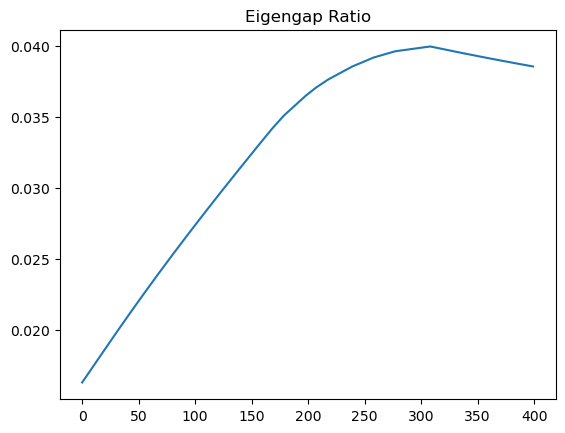

Final weights: [0.         0.         0.         0.         0.13519426 0.38256427
 0.16074716 0.16074716 0.16074716 0.         0.         0.
 0.         0.         0.        ]
===== Individual acc_score | nmi=====
K_GS_4: 0.7713(acc); 0.1428(nmi) | weight: 0.0000
K_GS_5: 0.5851(acc); 0.0558(nmi) | weight: 0.0000
K_GS_6: 0.7553(acc); 0.0874(nmi) | weight: 0.0000
K_GS_7: 0.6170(acc); 0.0141(nmi) | weight: 0.0000
K_GS_8: 0.5957(acc); 0.0122(nmi) | weight: 0.1352
K_GS_9: 0.8723(acc); 0.1831(nmi) | weight: 0.3826
K_SP_dijkstra: 0.6755(acc); 0.2106(nmi) | weight: 0.1607
K_SP_floyd_warshall: 0.6755(acc); 0.2106(nmi) | weight: 0.1607
K_SP_auto: 0.6755(acc); 0.2106(nmi) | weight: 0.1607
K_RW_0.5: 0.5106(acc); 0.3455(nmi) | weight: 0.0000
K_RW_1.0: 0.5160(acc); 0.3247(nmi) | weight: 0.0000
K_RW_1.5: 0.5160(acc); 0.3247(nmi) | weight: 0.0000
K_RW_2.0: 0.5160(acc); 0.3247(nmi) | weight: 0.0000
K_RW_2.5: 0.5160(acc); 0.3247(nmi) | weight: 0.0000
K_RW_3.0: 0.5160(acc); 0.3247(nmi) | weight: 0.0000
=

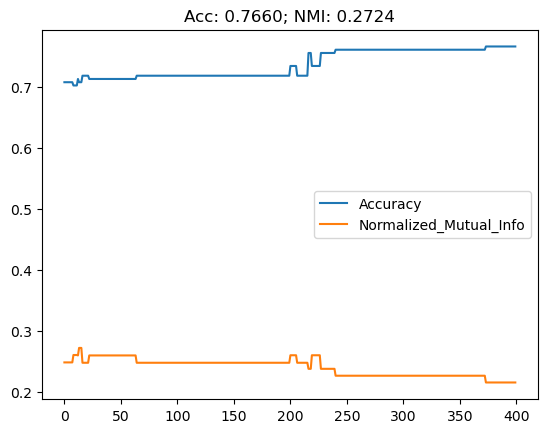

In [109]:
K_list = [K_dict[k] for k in K_dict.keys() if not k.startswith("K_WL")]
kernel_name = [k for k in K_dict.keys() if not k.startswith("K_WL")]
num_iter = 400
K_new, weights, score_dict = train(K_list, 'eigen_inv', 2, 1e-4, num_iter)
print("Final weights:", weights)
display_results(kernel_name, K_list, weights, score_dict, num_iter)

----- At No.1 iteration: sum: 1.0 norm: 0.2-----
eigengap ratio: [0.04198776]
acc_score: 0.5851063829787234; nmi: 0.17666774146146513

----- At No.11 iteration: sum: 1.0 norm: 0.2042-----
eigengap ratio: [0.04804514]
acc_score: 0.5851063829787234; nmi: 0.17666774146146513

----- At No.21 iteration: sum: 1.0 norm: 0.2159-----
eigengap ratio: [0.05484395]
acc_score: 0.5851063829787234; nmi: 0.17666774146146513

----- At No.31 iteration: sum: 1.0 norm: 0.2337-----
eigengap ratio: [0.06255216]
acc_score: 0.574468085106383; nmi: 0.18165729852067422

----- At No.41 iteration: sum: 1.0 norm: 0.2498-----
eigengap ratio: [0.06851629]
acc_score: 0.574468085106383; nmi: 0.18165729852067422

----- At No.51 iteration: sum: 1.0 norm: 0.2612-----
eigengap ratio: [0.07095534]
acc_score: 0.574468085106383; nmi: 0.18165729852067422

----- At No.61 iteration: sum: 1.0 norm: 0.2711-----
eigengap ratio: [0.07281533]
acc_score: 0.574468085106383; nmi: 0.18165729852067422

----- At No.71 iteration: sum: 1.0 

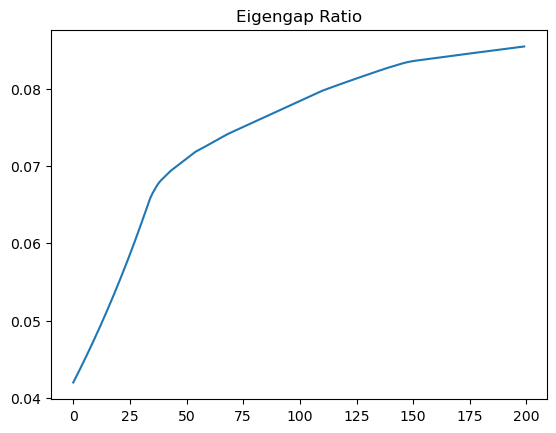

Final weights: [0.         0.02521272 0.09341479 0.         0.         0.
 0.         0.20230137 0.13870793 0.10772958 0.09971612 0.10748444
 0.         0.         0.         0.03278016 0.07811056 0.11454232
 0.         0.         0.         0.         0.         0.
 0.        ]
===== Individual acc_score | nmi=====
K_PM_4_6: 0.7287(acc); 0.3259(nmi) | weight: 0.0000
K_PM_5_6: 0.7287(acc); 0.3259(nmi) | weight: 0.0252
K_PM_6_6: 0.7287(acc); 0.3259(nmi) | weight: 0.0934
K_PM_4_7: 0.7234(acc); 0.3393(nmi) | weight: 0.0000
K_PM_4_8: 0.7234(acc); 0.3393(nmi) | weight: 0.0000
K_PM_4_9: 0.7234(acc); 0.3393(nmi) | weight: 0.0000
K_VH: 0.6330(acc); 0.0691(nmi) | weight: 0.0000
K_NH_3_8: 0.5691(acc); 0.1754(nmi) | weight: 0.2023
K_NH_2_8: 0.5798(acc); 0.1882(nmi) | weight: 0.1387
K_NH_1_8: 0.5691(acc); 0.1754(nmi) | weight: 0.1077
K_NH_1_4: 0.5691(acc); 0.1754(nmi) | weight: 0.0997
K_NH_1_6: 0.5691(acc); 0.1754(nmi) | weight: 0.1075
K_WL_1: 0.5532(acc); 0.1263(nmi) | weight: 0.0000
K_WL_3: 0.53

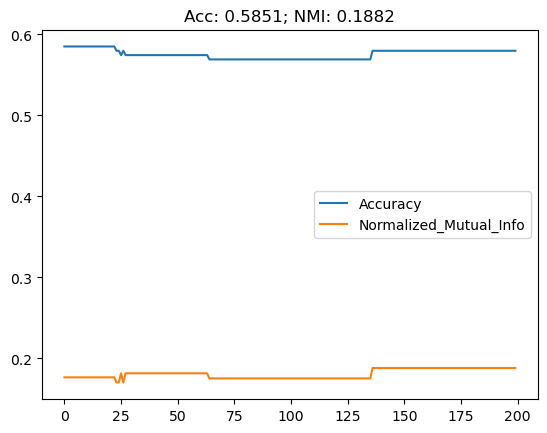

In [87]:
K_list = [K_dict[k] for k in K_dict.keys() if not k.startswith("K_RW")]
kernel_name = [k for k in K_dict.keys() if not k.startswith("K_RW")]
num_iter = 200
K_new, weights, score_dict = train(K_list, 'eigen_inv', 2, 1e-3, num_iter)
print("Final weights:", weights)
display_results(kernel_name, K_list, weights, score_dict, num_iter)

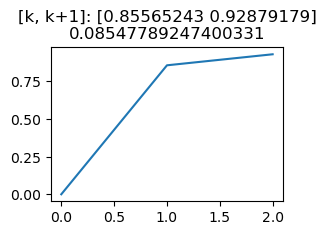

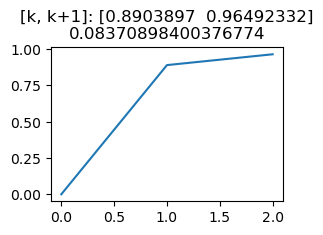

In [92]:
plot_eigens(K_new, 2) # 0.07828677
plot_eigens(K_dict['K_PM_5_6'], 2) # 0.08370899

----- At No.1 iteration: sum: 1.0 norm: 0.4099-----
eigengap ratio: [0.0769542]
acc_score: 0.723404255319149; nmi: 0.3392825877904391

----- At No.11 iteration: sum: 1.0 norm: 0.4111-----
eigengap ratio: [0.07715905]
acc_score: 0.723404255319149; nmi: 0.3392825877904391

----- At No.21 iteration: sum: 1.0 norm: 0.4127-----
eigengap ratio: [0.07736458]
acc_score: 0.723404255319149; nmi: 0.3392825877904391

----- At No.31 iteration: sum: 1.0 norm: 0.4146-----
eigengap ratio: [0.07757073]
acc_score: 0.723404255319149; nmi: 0.3392825877904391

----- At No.41 iteration: sum: 1.0 norm: 0.4168-----
eigengap ratio: [0.07777746]
acc_score: 0.723404255319149; nmi: 0.3392825877904391

----- At No.51 iteration: sum: 1.0 norm: 0.4193-----
eigengap ratio: [0.07798468]
acc_score: 0.723404255319149; nmi: 0.3392825877904391

----- At No.61 iteration: sum: 1.0 norm: 0.4222-----
eigengap ratio: [0.07819235]
acc_score: 0.723404255319149; nmi: 0.3392825877904391

----- At No.71 iteration: sum: 1.0 norm: 0.

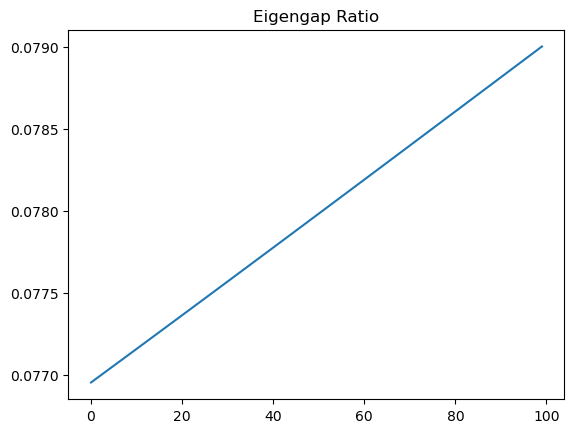

Final weights: [0.12465858 0.2054047  0.29064904 0.12618386 0.12768795 0.12541586]
===== Individual acc_score | nmi=====
K_PM_4_6: 0.7287(acc); 0.3259(nmi) | weight: 0.1247
K_PM_5_6: 0.7287(acc); 0.3259(nmi) | weight: 0.2054
K_PM_6_6: 0.7287(acc); 0.3259(nmi) | weight: 0.2906
K_PM_4_7: 0.7234(acc); 0.3393(nmi) | weight: 0.1262
K_PM_4_8: 0.7234(acc); 0.3393(nmi) | weight: 0.1277
K_PM_4_9: 0.7234(acc); 0.3393(nmi) | weight: 0.1254
===== Joint kernel =====


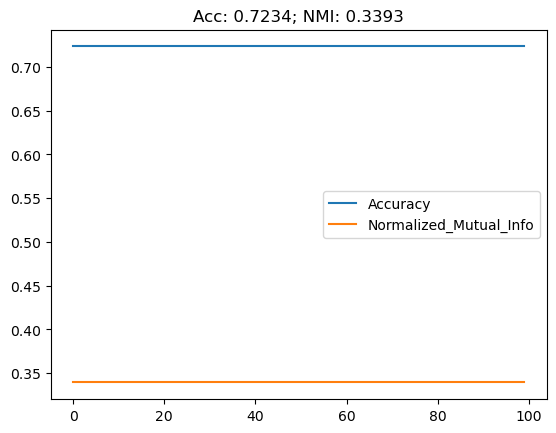

In [79]:
K_list = [K_dict[k] for k in K_dict.keys() if k.startswith("K_PM")]
kernel_name = [k for k in K_dict.keys() if k.startswith("K_PM")]
num_iter = 100
K_new, weights, score_dict = train(K_list, 'eigen', 2, 1e-3, num_iter)
print("Final weights:", weights)
display_results(kernel_name, K_list, weights, score_dict, num_iter)